
Business Case:OLA-Ensemble Learning
by Akul Vinod

<img src="https://1000marcas.net/wp-content/uploads/2022/10/Ola-Cabs-Logo.png">

## **About Ola**  
Ola is a major player in the ride-hailing industry, known for its vast network of drivers and vehicles, providing convenient and affordable transportation options. However, it faces significant challenges in driver recruitment and retention, which directly impact its operational efficiency and customer satisfaction.

## **Problem Statement**

Ola is struggling with high attrition rates among its drivers. This churn creates multiple challenges:  
1. **Operational Challenges**: A constant need to recruit new drivers, which is costly and resource-intensive.  
2. **Retention Issues**: Difficulty in retaining existing drivers who might leave due to dissatisfaction, better offers, or other factors.  
3. **Business Impact**: Frequent driver exits impact morale, operational consistency, and financial stability since acquiring new drivers is more expensive than retaining current ones.  

The goal is to predict whether a driver will leave the company based on historical and demographic data, enabling Ola to take proactive steps to improve retention.

## **Objective**  

The primary objective is:  
- **Predict driver attrition** using available data (demographics, tenure, performance, etc.).  
- This prediction will help Ola identify at-risk drivers and design targeted interventions (e.g., incentives, support programs, or policy changes) to retain them and reduce operational costs.  


## **Concepts Used**  
This project incorporates the following key data science and machine learning techniques:  

1. **Ensemble Learning - Bagging**:  
   - A technique that combines predictions from multiple models (e.g., Random Forest) to reduce variance and improve prediction stability and accuracy.  

2. **Ensemble Learning - Boosting**:  
   - An iterative approach that focuses on correcting errors made by weak models in the previous iterations (e.g., Gradient Boosting, XGBoost).  

3. **KNN Imputation of Missing Values**:  
   - A method to handle missing data by imputing values based on the similarity (proximity) of data points.  

4. **Working with an Imbalanced Dataset**:  
   - Addressing class imbalance where attrition (leaving drivers) might be a minority class compared to non-attrition. Techniques such as SMOTE (Synthetic Minority Oversampling Technique), under-sampling, or class-weighted algorithms may be used to balance the dataset for better model performance.

## **Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

## **Exploring the data...**

In [4]:
data = pd.read_csv('ola_driver_scaler.csv')

In [5]:
data.head()

Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  \
0           0  01/01/19          1  28.0     0.0  C23                2   
1           1  02/01/19          1  28.0     0.0  C23                2   
2           2  03/01/19          1  28.0     0.0  C23                2   
3           3  11/01/20          2  31.0     0.0   C7                2   
4           4  12/01/20          2  31.0     0.0   C7                2   

   Income Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0   57387      24/12/18             NaN                    1      1   
1   57387      24/12/18             NaN                    1      1   
2   57387      24/12/18        03/11/19                    1      1   
3   67016      11/06/20             NaN                    2      2   
4   67016      11/06/20             NaN                    2      2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 2  
2                     0                 2  
3                     0                 1  
4                     0                 1

In [6]:
# Checking the number of rows and columns
print(f"The number of rows: {data.shape[0]:,} \nThe number of columns: {data.shape[1]}")

The number of rows: 19,104 
The number of columns: 14


In [7]:
# Check all column names
data.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

## **Observations on Data**

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


**OBSERVATION**

1. **Data Overview**:  
   - Total entries: **19,104 rows**  
   - Total columns: **14**  
   - Missing data in columns:
     - **Age**: 61 missing values.
     - **Gender**: 52 missing values.
     - **LastWorkingDate**: Majority missing (17,488 missing values, only 1,616 non-null). Likely indicates currently active drivers.

2. **Columns Details**:  
   - `MMMM-YY` (object): Monthly reporting date. Time-based feature for trend analysis.
   - `Driver_ID` (int64): Unique identifier for drivers.
   - `Age` (float64): Driver's age, has 61 missing values.
   - `Gender` (float64): Encoded (Male = 0, Female = 1). Missing values need imputation.
   - `City` (object): Categorical variable, encoded city codes.
   - `Education_Level` (int64): Encoded education levels (0 = 10+, 1 = 12+, 2 = graduate).
   - `Income` (int64): Monthly average income of the driver.
   - `DateOfJoining` (object): Date when the driver joined the company.
   - `LastWorkingDate` (object): Date when the driver left (or null if still active).
   - `Joining Designation` (int64): Initial designation of the driver.
   - `Grade` (int64): Grade assigned to the driver during the reporting period.
   - `Total Business Value` (int64): Monthly business value, with potential for negative values indicating cancellations or refunds.
   - `Quarterly Rating` (int64): Driver performance rating (1 to 5).

3. **Data Challenges**:  
   - **Missing Values**: Key variables like `Age`, `Gender`, and especially `LastWorkingDate` have missing values requiring appropriate handling.  
   - **Imbalanced Dataset**: Drivers with `LastWorkingDate` populated are likely those who have left, potentially creating an imbalance in attrition prediction.  
   - **Temporal Features**: `MMMM-YY`, `DateOfJoining`, and `LastWorkingDate` need preprocessing to derive tenure and time-based features.

4. **Potential Derived Features**:  
   - **Driver Tenure**: Difference between reporting date (`MMMM-YY`) and joining date (`DateOfJoining`).
   - **Activity Status**: Binary column indicating whether the driver is active (`LastWorkingDate` is null) or has left (`LastWorkingDate` populated).
   - **Income Trends**: Calculate income trends over time for active drivers.
   - **Performance Metrics**: Analyze `Quarterly Rating` and `Total Business Value` trends.

In [9]:
# Number of unique values in each coluumn and datatype:
print("Number of unique values in each coluumn and datatype:")
print("-" * 55)
for i, elem in (enumerate(data.columns)):
  print(f"{i+1}. {elem}: {data[elem].nunique(), data[elem].dtypes}")

Number of unique values in each coluumn and datatype:
-------------------------------------------------------
1. Unnamed: 0: (19104, dtype('int64'))
2. MMM-YY: (24, dtype('O'))
3. Driver_ID: (2381, dtype('int64'))
4. Age: (36, dtype('float64'))
5. Gender: (2, dtype('float64'))
6. City: (29, dtype('O'))
7. Education_Level: (3, dtype('int64'))
8. Income: (2383, dtype('int64'))
9. Dateofjoining: (869, dtype('O'))
10. LastWorkingDate: (493, dtype('O'))
11. Joining Designation: (5, dtype('int64'))
12. Grade: (5, dtype('int64'))
13. Total Business Value: (10181, dtype('int64'))
14. Quarterly Rating: (4, dtype('int64'))


## **Processing the data**

In [10]:
# Creating a deep copy
df1 = data.copy()

In [11]:
# Remove Unnamed column
df1.drop('Unnamed: 0', axis=1,inplace=True)

In [12]:
# Doing the required operations for each columns
df1 = df1.rename(columns={'MMM-YY': 'Reporting_Date'})
df1['Reporting_Date'] = pd.to_datetime(df1['Reporting_Date'], format='mixed',errors='coerce')
df1['Dateofjoining'] = pd.to_datetime(df1['Dateofjoining'], format='mixed',errors='coerce')
df1['LastWorkingDate'] = pd.to_datetime(df1['LastWorkingDate'], format='mixed',errors='coerce')
df1['City'] = df1['City'].astype('category') #OHE
df1["Gender"].replace({0.0:"Male",1.0:"Female"},inplace=True)
df1['Gender'] = df1['Gender'].astype('category') #Convert to int after EDA
df1['Education_Level'] = df1['Education_Level'].astype('category') #Convert to int after EDA
df1['Joining Designation'] = df1['Joining Designation'].astype('category') #Convert to int after EDA
df1['Grade'] = df1['Grade'].astype('category') #Convert to int after EDA

In [13]:
print(df1.dtypes)

Reporting_Date          datetime64[ns]
Driver_ID                        int64
Age                            float64
Gender                        category
City                          category
Education_Level               category
Income                           int64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Joining Designation           category
Grade                         category
Total Business Value             int64
Quarterly Rating                 int64
dtype: object


### Feature Engineering

##### Creating Target feature

In [14]:
df1.head(15)

Reporting_Date  Driver_ID   Age  Gender City Education_Level  Income  \
0      2019-01-01          1  28.0    Male  C23               2   57387   
1      2019-02-01          1  28.0    Male  C23               2   57387   
2      2019-03-01          1  28.0    Male  C23               2   57387   
3      2020-11-01          2  31.0    Male   C7               2   67016   
4      2020-12-01          2  31.0    Male   C7               2   67016   
5      2019-12-01          4  43.0    Male  C13               2   65603   
6      2020-01-01          4  43.0    Male  C13               2   65603   
7      2020-02-01          4  43.0    Male  C13               2   65603   
8      2020-03-01          4  43.0    Male  C13               2   65603   
9      2020-04-01          4  43.0    Male  C13               2   65603   
10     2019-01-01          5  29.0    Male   C9               0   46368   
11     2019-02-01          5  29.0    Male   C9               0   46368   
12     2019-03-01          5  29.0    Male   C9               0   46368   
13     2020-08-01          6  31.0  Female  C11               1   78728   
14     2020-09-01          6  31.0  Female  C11               1   78728   

   Dateofjoining LastWorkingDate Joining Designation Grade  \
0     2018-12-24             NaT                   1     1   
1     2018-12-24             NaT                   1     1   
2     2018-12-24      2019-03-11                   1     1   
3     2020-11-06             NaT                   2     2   
4     2020-11-06             NaT                   2     2   
5     2019-12-07             NaT                   2     2   
6     2019-12-07             NaT                   2     2   
7     2019-12-07             NaT                   2     2   
8     2019-12-07             NaT                   2     2   
9     2019-12-07      2020-04-27                   2     2   
10    2019-01-09             NaT                   1     1   
11    2019-01-09             NaT                   1     1   
12    2019-01-09      2019-03-07                   1     1   
13    2020-07-31             NaT                   3     3   
14    2020-07-31             NaT                   3     3   

    Total Business Value  Quarterly Rating  
0                2381060                 2  
1                -665480                 2  
2                      0                 2  
3                      0                 1  
4                      0                 1  
5                      0                 1  
6                      0                 1  
7                      0                 1  
8                 350000                 1  
9                      0                 1  
10                     0                 1  
11                120360                 1  
12                     0                 1  
13                     0                 1  
14                     0                 1

In [15]:
churn =  (df1.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()
churn['LastWorkingDate'].replace({True:0,False:1},inplace=True) # Churned -> 1, not churned -> 0
churn.rename(columns={'LastWorkingDate':'churn'},inplace=True)
churn.head()

Driver_ID  churn
0          1      1
1          2      0
2          4      1
3          5      1
4          6      0

Quarterly Rating

In [16]:
# If Quarterly Rating has increased than value 1 else 0
QR1 =  (df1.groupby('Driver_ID').agg({'Quarterly Rating':'first'})).reset_index()
QR2 = (df1.groupby('Driver_ID').agg({'Quarterly Rating':'last'})).reset_index()

In [17]:
QR1.isna().sum(),QR2.isna().sum()

(Driver_ID           0
 Quarterly Rating    0
 dtype: int64,
 Driver_ID           0
 Quarterly Rating    0
 dtype: int64)

In [18]:
churn = churn.merge(QR1,on='Driver_ID')
churn = churn.merge(QR2,on='Driver_ID')
churn['Rating_increase']=np.where(churn['Quarterly Rating_x'] < churn['Quarterly Rating_y'], 1,0)

In [19]:
churn.head()

Driver_ID  churn  Quarterly Rating_x  Quarterly Rating_y  Rating_increase
0          1      1                   2                   2                0
1          2      0                   1                   1                0
2          4      1                   1                   1                0
3          5      1                   1                   1                0
4          6      0                   1                   2                1

In [20]:
plt.figure(figsize=(6,5))
label = churn['Rating_increase'].value_counts().plot(kind="bar", color=['yellowgreen', 'black'])
for i in label.containers:
    label.bar_label(i)
plt.xticks(rotation=360)
plt.xlabel("Rating_increase")
plt.ylabel("Count")
plt.title("Rating_increase")
plt.show()

**🔍OBSERVATION🔎**

- This indicates that a significant majority 2023 (approximately 85%) of the drivers are either maintaining the same rating or experiencing a decline.
- Only 358 drivers (approximately 15%) showed an improvement in their ratings during the same period.

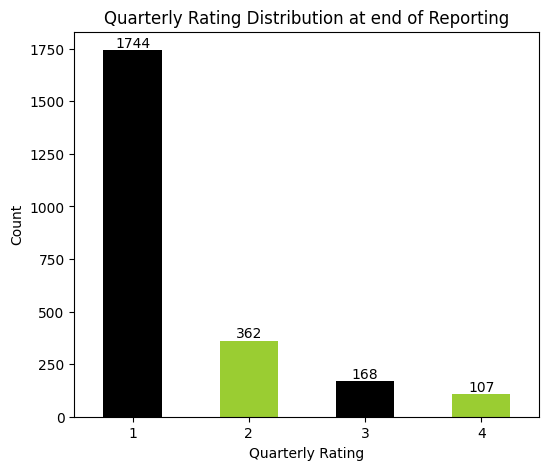

In [21]:
plt.figure(figsize=(6,5))
label = churn['Quarterly Rating_y'].value_counts().plot(kind="bar", color=['black','yellowgreen'])
for i in label.containers:
    label.bar_label(i)
plt.xticks(rotation=360)
plt.xlabel("Quarterly Rating")
plt.ylabel("Count")
plt.title("Quarterly Rating Distribution at end of Reporting")
plt.show()

**🔍OBSERVATION🔎**

- The majority of drivers (1,744 out of the total) have a Quarterly Rating of 1. This indicates that most drivers are rated poorly on their quarterly performance metrics.
- The small number of drivers with higher ratings (3 or 4) suggests that most drivers are underperforming or the rating system is stringent.

Income

In [22]:
income1 =  (df1.groupby('Driver_ID').agg({'Income':'first'})['Income']).reset_index()
income2 = (df1.groupby('Driver_ID').agg({'Income':'last'})['Income']).reset_index()

In [23]:
income1.shape,income2.shape

((2381, 2), (2381, 2))

In [24]:
income1.isna().sum(),income2.isna().sum()

(Driver_ID    0
 Income       0
 dtype: int64,
 Driver_ID    0
 Income       0
 dtype: int64)

In [25]:
churn = churn.merge(income1,on='Driver_ID')
churn = churn.merge(income2,on='Driver_ID')
churn['Income_increase'] = np.where(churn['Income_x'] < churn['Income_y'], 1,0)

In [26]:
churn['Income_increase'].value_counts()

Income_increase
0    2338
1      43
Name: count, dtype: int64

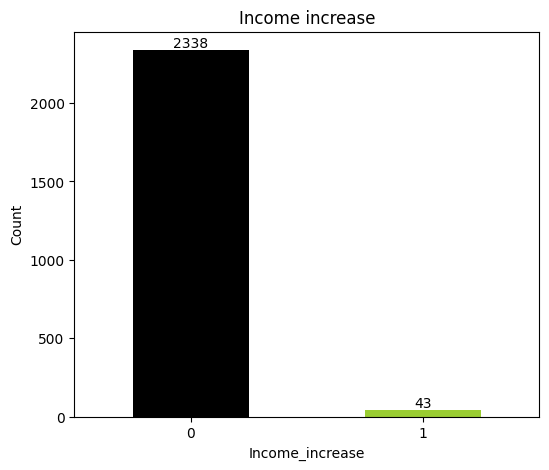

In [27]:
plt.figure(figsize=(6,5))
label = churn['Income_increase'].value_counts().plot(kind="bar", color=['black','yellowgreen'])
for i in label.containers:
    label.bar_label(i)
plt.xticks(rotation=360)
plt.xlabel("Income_increase")
plt.ylabel("Count")
plt.title("Income increase")
plt.show()

**🔍OBSERVATION🔎**

- Out of the total drivers, 2,338 drivers (approximately 98%) either experienced no increase or a decrease in their income over the observed period. This reflects a significant challenge in driver satisfaction, as stagnant or declining income can lead to dissatisfaction and potentially higher churn.

- Only 43 drivers (approximately 2%) experienced an increase in income during the period. This extremely low percentage indicates that income progression is rare, which could discourage drivers from staying loyal to Ola.

In [28]:
churn.columns

Index(['Driver_ID', 'churn', 'Quarterly Rating_x', 'Quarterly Rating_y',
       'Rating_increase', 'Income_x', 'Income_y', 'Income_increase'],
      dtype='object')

In [29]:
target = churn[['Driver_ID','churn','Rating_increase','Income_increase']]
target.head()

Driver_ID  churn  Rating_increase  Income_increase
0          1      1                0                0
1          2      0                0                0
2          4      1                0                0
3          5      1                0                0
4          6      0                1                0

#### Aggregated dataframe

In [30]:
# Creating a deep copy
df = df1.copy()

In [31]:
functions = {'Reporting_Date':'count',
             'Driver_ID':'first',
             'Age':'max',
             'Gender':'last',
             'City':'last',
             'Education_Level':'last',
             'Dateofjoining':'first',
             'LastWorkingDate':'last',
             'Grade':'last',
             'Total Business Value':'sum',
             'Income':'last',
             'Joining Designation':'last',
             'Quarterly Rating':'mean'} #last
df = df.groupby('Driver_ID').aggregate(functions).reset_index(drop=True)
df.rename(columns={'Reporting_Date':'Reportings'},inplace=True)

In [32]:
# Merge with target
df = df.merge(target,on='Driver_ID')

In [33]:
# Maintaining decimal places
df['Quarterly Rating'] = round(df['Quarterly Rating'],1)

In [34]:
df.head()

Reportings  Driver_ID   Age  Gender City Education_Level Dateofjoining  \
0           3          1  28.0    Male  C23               2    2018-12-24   
1           2          2  31.0    Male   C7               2    2020-11-06   
2           5          4  43.0    Male  C13               2    2019-12-07   
3           3          5  29.0    Male   C9               0    2019-01-09   
4           5          6  31.0  Female  C11               1    2020-07-31   

  LastWorkingDate Grade  Total Business Value  Income Joining Designation  \
0      2019-03-11     1               1715580   57387                   1   
1             NaT     2                     0   67016                   2   
2      2020-04-27     2                350000   65603                   2   
3      2019-03-07     1                120360   46368                   1   
4             NaT     3               1265000   78728                   3   

   Quarterly Rating  churn  Rating_increase  Income_increase  
0               2.0      1                0                0  
1               1.0      0                0                0  
2               1.0      1                0                0  
3               1.0      1                0                0  
4               1.6      0                1                0

In [35]:
df.shape

(2381, 16)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Reportings            2381 non-null   int64         
 1   Driver_ID             2381 non-null   int64         
 2   Age                   2381 non-null   float64       
 3   Gender                2381 non-null   category      
 4   City                  2381 non-null   category      
 5   Education_Level       2381 non-null   category      
 6   Dateofjoining         2381 non-null   datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Grade                 2381 non-null   category      
 9   Total Business Value  2381 non-null   int64         
 10  Income                2381 non-null   int64         
 11  Joining Designation   2381 non-null   category      
 12  Quarterly Rating      2381 non-null   float64       
 13  churn             

In [37]:
# Doing the required operations for each columns
#df['Reportings'] = df['Reportings'].astype('category')
df['Age'] = df['Age'].astype('int')
df['churn'] = df['churn'].astype('category')
#df['Quarterly Rating'] = df['Quarterly Rating'].astype('category')
df['Rating_increase'] = df['Rating_increase'].astype('category')
df['Income_increase'] = df['Income_increase'].astype('category')

In [38]:
print(df.dtypes)

Reportings                       int64
Driver_ID                        int64
Age                              int64
Gender                        category
City                          category
Education_Level               category
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Grade                         category
Total Business Value             int64
Income                           int64
Joining Designation           category
Quarterly Rating               float64
churn                         category
Rating_increase               category
Income_increase               category
dtype: object


In [39]:
# Number of unique values in each column and datatype:
print("Number of unique values in each column and datatype:")
print("-" * 55)
for i, elem in (enumerate(df.columns)):
  print(f"{i+1}. {elem}: {df[elem].nunique(), df[elem].dtypes}")

Number of unique values in each column and datatype:
-------------------------------------------------------
1. Reportings: (24, dtype('int64'))
2. Driver_ID: (2381, dtype('int64'))
3. Age: (36, dtype('int64'))
4. Gender: (2, CategoricalDtype(categories=['Female', 'Male'], ordered=False, categories_dtype=object))
5. City: (29, CategoricalDtype(categories=['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17',
                  'C18', 'C19', 'C2', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25',
                  'C26', 'C27', 'C28', 'C29', 'C3', 'C4', 'C5', 'C6', 'C7',
                  'C8', 'C9'],
, ordered=False, categories_dtype=object))
6. Education_Level: (3, CategoricalDtype(categories=[0, 1, 2], ordered=False, categories_dtype=int64))
7. Dateofjoining: (869, dtype('<M8[ns]'))
8. LastWorkingDate: (493, dtype('<M8[ns]'))
9. Grade: (5, CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=False, categories_dtype=int64))
10. Total Business Value: (1629, dtype('int64'))
11. Income: (

### Check for Duplicate

> Add blockquote



In [40]:
df[df.duplicated]

Empty DataFrame
Columns: [Reportings, Driver_ID, Age, Gender, City, Education_Level, Dateofjoining, LastWorkingDate, Grade, Total Business Value, Income, Joining Designation, Quarterly Rating, churn, Rating_increase, Income_increase]
Index: []

### Missing value treatment</font>

In [41]:
# How many percentage of data is missing in each column
missing_value = pd.DataFrame({'Missing Value': df.isnull().sum(), 'Percentage': (((df.isnull().sum() / len(df))*100)).round(2)})
missing_value.sort_values(by='Percentage', ascending=False)

Missing Value  Percentage
LastWorkingDate                 765       32.13
Reportings                        0        0.00
Age                               0        0.00
Driver_ID                         0        0.00
Gender                            0        0.00
City                              0        0.00
Education_Level                   0        0.00
Dateofjoining                     0        0.00
Grade                             0        0.00
Total Business Value              0        0.00
Income                            0        0.00
Joining Designation               0        0.00
Quarterly Rating                  0        0.00
churn                             0        0.00
Rating_increase                   0        0.00
Income_increase                   0        0.00

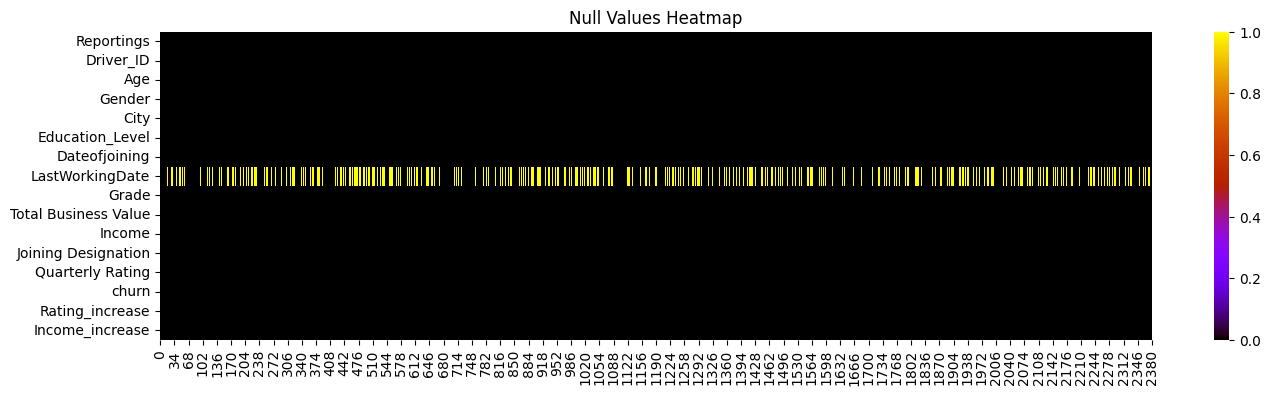

In [42]:
# Null value heatmap:
plt.figure(figsize = (16,4))
sns.heatmap(df.isnull().T, cmap='gnuplot')
plt.title('Null Values Heatmap')
plt.show()

**🔍OBSERVATION🔎**
- Lets keep the last working dat as it is because if it is null then the person is still working


In [43]:
df.head()

Reportings  Driver_ID  Age  Gender City Education_Level Dateofjoining  \
0           3          1   28    Male  C23               2    2018-12-24   
1           2          2   31    Male   C7               2    2020-11-06   
2           5          4   43    Male  C13               2    2019-12-07   
3           3          5   29    Male   C9               0    2019-01-09   
4           5          6   31  Female  C11               1    2020-07-31   

  LastWorkingDate Grade  Total Business Value  Income Joining Designation  \
0      2019-03-11     1               1715580   57387                   1   
1             NaT     2                     0   67016                   2   
2      2020-04-27     2                350000   65603                   2   
3      2019-03-07     1                120360   46368                   1   
4             NaT     3               1265000   78728                   3   

   Quarterly Rating churn Rating_increase Income_increase  
0               2.0     1               0               0  
1               1.0     0               0               0  
2               1.0     1               0               0  
3               1.0     1               0               0  
4               1.6     0               1               0

In [44]:
# Display the range of attributes
print("Range of attributes:")
print("-" * 20)
df.describe(include='all').T

Range of attributes:
--------------------


count unique   top    freq  \
Reportings            2381.0    NaN   NaN     NaN   
Driver_ID             2381.0    NaN   NaN     NaN   
Age                   2381.0    NaN   NaN     NaN   
Gender                  2381      2  Male    1404   
City                    2381     29   C20     152   
Education_Level       2381.0    3.0   2.0   802.0   
Dateofjoining           2381    NaN   NaN     NaN   
LastWorkingDate         1616    NaN   NaN     NaN   
Grade                 2381.0    5.0   2.0   855.0   
Total Business Value  2381.0    NaN   NaN     NaN   
Income                2381.0    NaN   NaN     NaN   
Joining Designation   2381.0    5.0   1.0  1026.0   
Quarterly Rating      2381.0    NaN   NaN     NaN   
churn                 2381.0    2.0   1.0  1616.0   
Rating_increase       2381.0    2.0   0.0  2023.0   
Income_increase       2381.0    2.0   0.0  2338.0   

                                               mean                  min  \
Reportings                                  8.02352                  1.0   
Driver_ID                               1397.559009                  1.0   
Age                                       33.663167                 21.0   
Gender                                          NaN                  NaN   
City                                            NaN                  NaN   
Education_Level                                 NaN                  NaN   
Dateofjoining         2019-02-08 07:14:50.550189056  2013-04-01 00:00:00   
LastWorkingDate       2019-12-21 20:59:06.534653440  2018-12-31 00:00:00   
Grade                                           NaN                  NaN   
Total Business Value                 4586741.822764           -1385530.0   
Income                                 59334.157077              10747.0   
Joining Designation                             NaN                  NaN   
Quarterly Rating                           1.567535                  1.0   
churn                                           NaN                  NaN   
Rating_increase                                 NaN                  NaN   
Income_increase                                 NaN                  NaN   

                                      25%                  50%  \
Reportings                            3.0                  5.0   
Driver_ID                           695.0               1400.0   
Age                                  29.0                 33.0   
Gender                                NaN                  NaN   
City                                  NaN                  NaN   
Education_Level                       NaN                  NaN   
Dateofjoining         2018-06-29 00:00:00  2019-07-21 00:00:00   
LastWorkingDate       2019-06-06 00:00:00  2019-12-20 12:00:00   
Grade                                 NaN                  NaN   
Total Business Value                  0.0             817680.0   
Income                            39104.0              55315.0   
Joining Designation                   NaN                  NaN   
Quarterly Rating                      1.0                  1.0   
churn                                 NaN                  NaN   
Rating_increase                       NaN                  NaN   
Income_increase                       NaN                  NaN   

                                      75%                  max             std  
Reportings                           10.0                 24.0         6.78359  
Driver_ID                          2100.0               2788.0      806.161628  
Age                                  37.0                 58.0        5.983375  
Gender                                NaN                  NaN             NaN  
City                                  NaN                  NaN             NaN  
Education_Level                       NaN                  NaN             NaN  
Dateofjoining         2020-05-02 00:00:00  2020-12-28 00:00:00             NaN  
LastWorkingDate       2020-07-03 00:00:00  2020-12-28 00:

In [45]:
# Display the statistical summary
print("statistical summary:")
print("-" * 20)
df.describe().T

statistical summary:
--------------------


count                           mean  \
Reportings            2381.0                        8.02352   
Driver_ID             2381.0                    1397.559009   
Age                   2381.0                      33.663167   
Dateofjoining           2381  2019-02-08 07:14:50.550189056   
LastWorkingDate         1616  2019-12-21 20:59:06.534653440   
Total Business Value  2381.0                 4586741.822764   
Income                2381.0                   59334.157077   
Quarterly Rating      2381.0                       1.567535   

                                      min                  25%  \
Reportings                            1.0                  3.0   
Driver_ID                             1.0                695.0   
Age                                  21.0                 29.0   
Dateofjoining         2013-04-01 00:00:00  2018-06-29 00:00:00   
LastWorkingDate       2018-12-31 00:00:00  2019-06-06 00:00:00   
Total Business Value           -1385530.0                  0.0   
Income                            10747.0              39104.0   
Quarterly Rating                      1.0                  1.0   

                                      50%                  75%  \
Reportings                            5.0                 10.0   
Driver_ID                          1400.0               2100.0   
Age                                  33.0                 37.0   
Dateofjoining         2019-07-21 00:00:00  2020-05-02 00:00:00   
LastWorkingDate       2019-12-20 12:00:00  2020-07-03 00:00:00   
Total Business Value             817680.0            4173650.0   
Income                            55315.0              75986.0   
Quarterly Rating                      1.0                  2.0   

                                      max             std  
Reportings                           24.0         6.78359  
Driver_ID                          2788.0      806.161628  
Age                                  58.0        5.983375  
Dateofjoining         2020-12-28 00:00:00             NaN  
LastWorkingDate       2020-12-28 00:00:00             NaN  
Total Business Value           95331060.0  9127115.313446  
Income                           188418.0    28383.666384  
Quarterly Rating                      4.0        0.720405

**🔍OBSERVATION🔎**

1. **Age**:
   - The average age of drivers is approximately 33.66 years.
   - The age ranges from 21 to 58 years, with a standard deviation of around 5.98 years.

2. **Gender**:
   - The dataset is predominantly male, with 1404 male drivers (around 59% of the dataset) and the remaining being female.

3. **City**:
   - The most frequent city is `C20`, with 152 drivers working there, but there are 29 distinct cities, showing a diverse distribution of drivers.

4. **Total Business Value**:
   - The average total business value per driver is around 4.59 million, but the values range from a minimum of -1.39 million to a maximum of 95.33 million, suggesting significant variation in business performance among drivers.

5. **Income**:
   - The average income is approximately 59,334, with a minimum income of 10,747 and a maximum of 188,418, indicating a wide spread of earnings among drivers.

## **Exploratory data analysis**📊📈

### Univariate Analysis</font>

In [46]:
# Selecting the categorical columns
categorical_cols = df.select_dtypes(include='category').columns
categorical_cols

Index(['Gender', 'City', 'Education_Level', 'Grade', 'Joining Designation',
       'churn', 'Rating_increase', 'Income_increase'],
      dtype='object')

In [47]:
# Required colour palette
green_palette = ['#187c19', '#69b41e', '#8dc71e', '#b8d53d'] #'#0d5b11',
#green_palette = ['#F5FAD1', '#D1EBA1', '#A6D577', '#76C352', '#438032', '#189E1E', '#028B22']

In [48]:
# Value couts for categorical columns
for elem in categorical_cols:
  print(f"Column Name: {elem}")
  print(df[elem].value_counts())
  print()
  print(round(((df[elem].value_counts(normalize=True)) * 100),2))
  print("_" * 35)
  print()

Column Name: Gender
Gender
Male      1404
Female     977
Name: count, dtype: int64

Gender
Male      58.97
Female    41.03
Name: proportion, dtype: float64
___________________________________

Column Name: City
City
C20    152
C15    101
C29     96
C26     93
C8      89
C27     89
C10     86
C16     84
C22     82
C3      82
C28     82
C12     81
C1      80
C5      80
C21     79
C14     79
C6      78
C4      77
C7      76
C9      75
C23     74
C25     74
C24     73
C19     72
C2      72
C13     71
C17     71
C18     69
C11     64
Name: count, dtype: int64

City
C20    6.38
C15    4.24
C29    4.03
C26    3.91
C8     3.74
C27    3.74
C10    3.61
C16    3.53
C22    3.44
C3     3.44
C28    3.44
C12    3.40
C1     3.36
C5     3.36
C21    3.32
C14    3.32
C6     3.28
C4     3.23
C7     3.19
C9     3.15
C23    3.11
C25    3.11
C24    3.07
C19    3.02
C2     3.02
C13    2.98
C17    2.98
C18    2.90
C11    2.69
Name: proportion, dtype: float64
___________________________________

Column Name: Ed

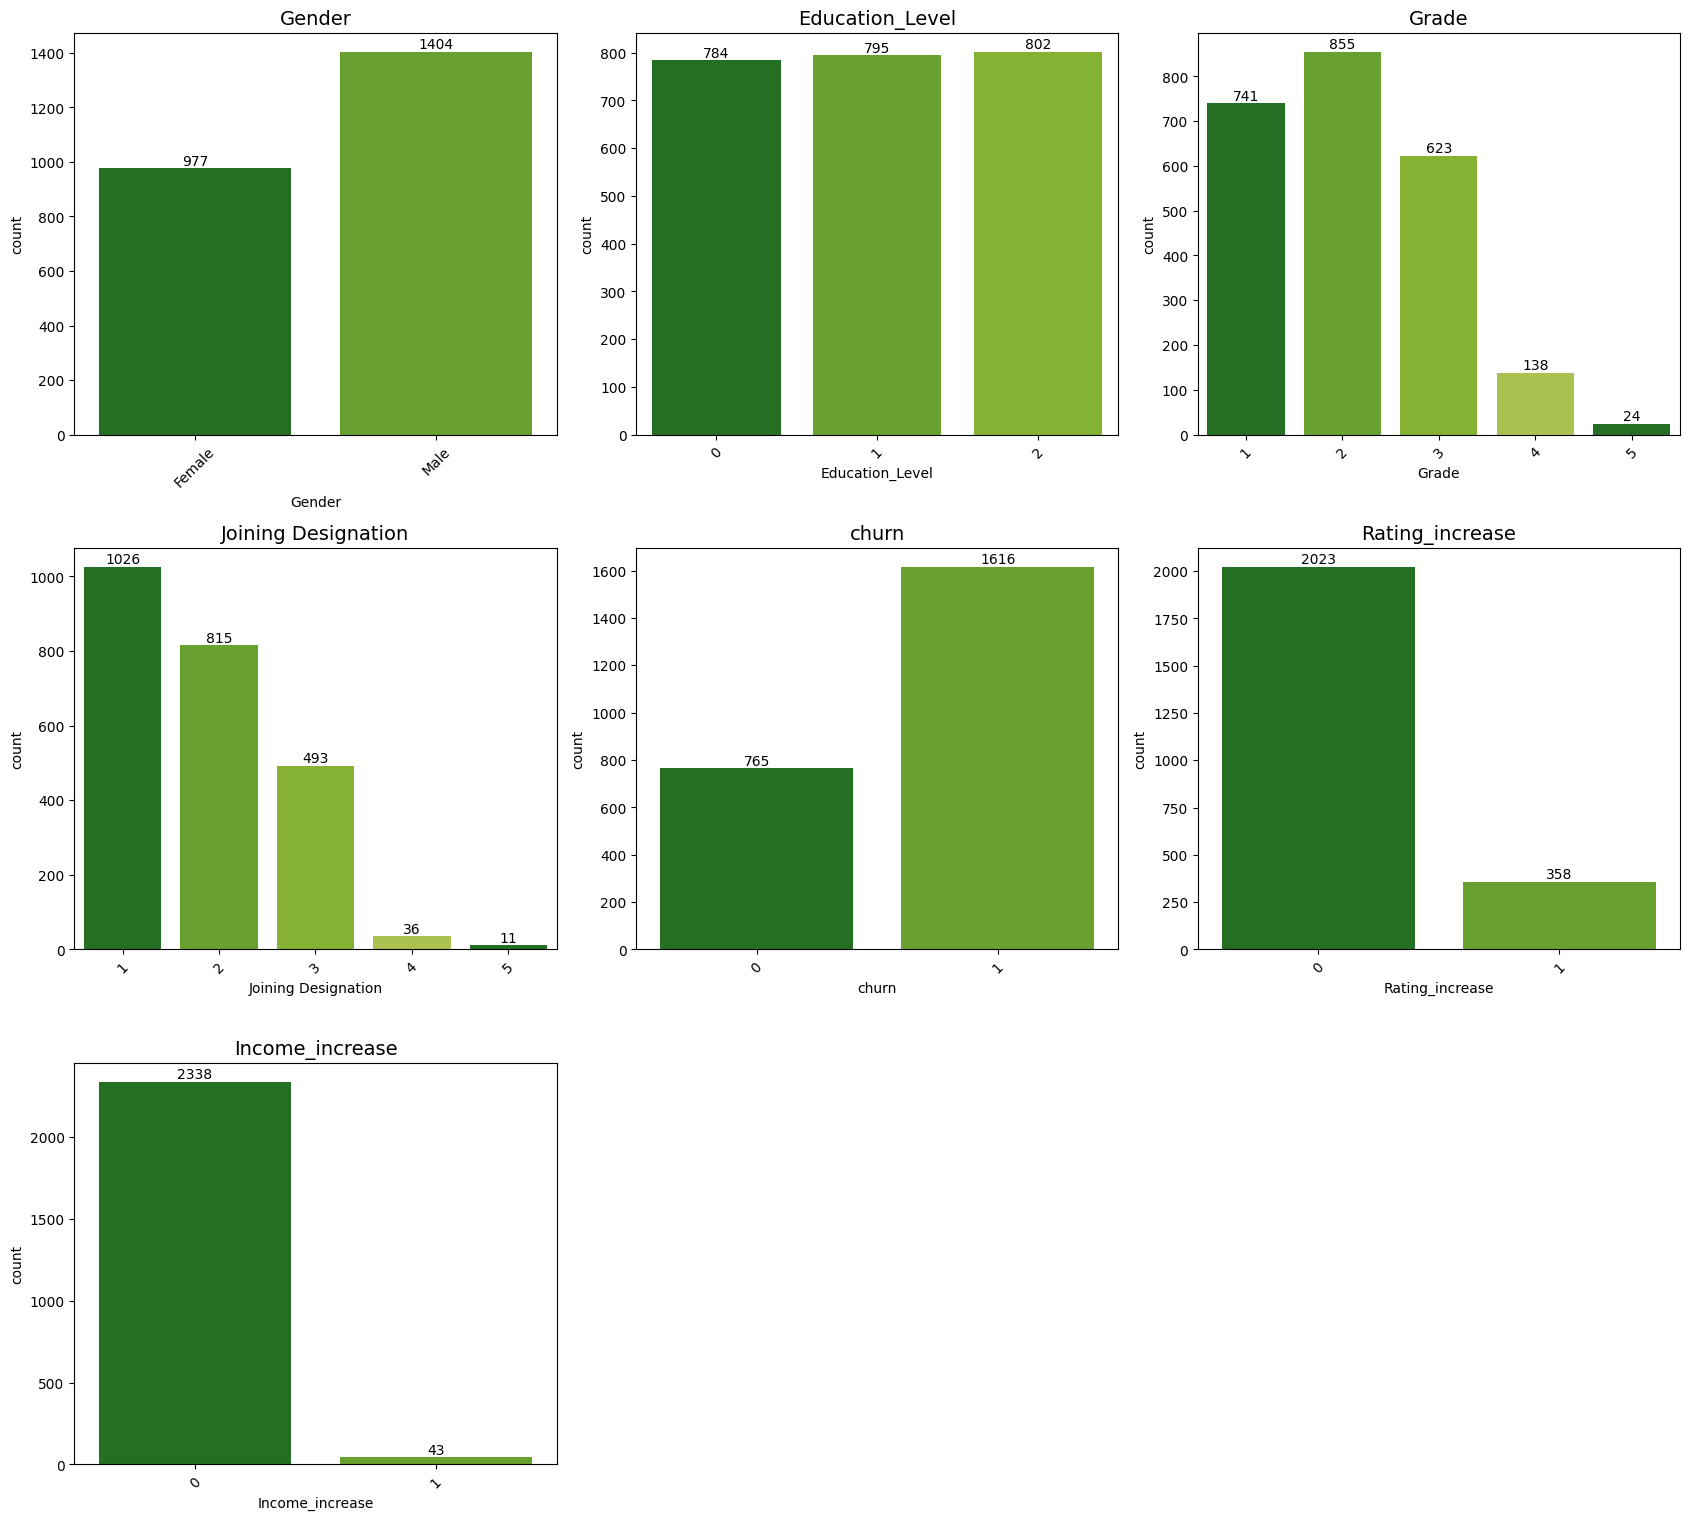

In [49]:
# Count Plots for Categorical features
req_cat_col_plot = ['Gender', 'Education_Level', 'Grade', 'Joining Designation','churn', 'Rating_increase', 'Income_increase']

plt.figure(figsize=(17,20))
for i, elem in enumerate(req_cat_col_plot):
  plt.subplot(4,3,i+1)
  label = sns.countplot(data = df, x = elem, palette = green_palette)
  for i in label.containers:
    label.bar_label(i)

  plt.xticks(rotation = 45)
  plt.ylabel('count')
  plt.title(elem, fontsize=14)

#plt.suptitle("Count Plots for Categorical features", fontsize = 18)
plt.tight_layout()
plt.show()

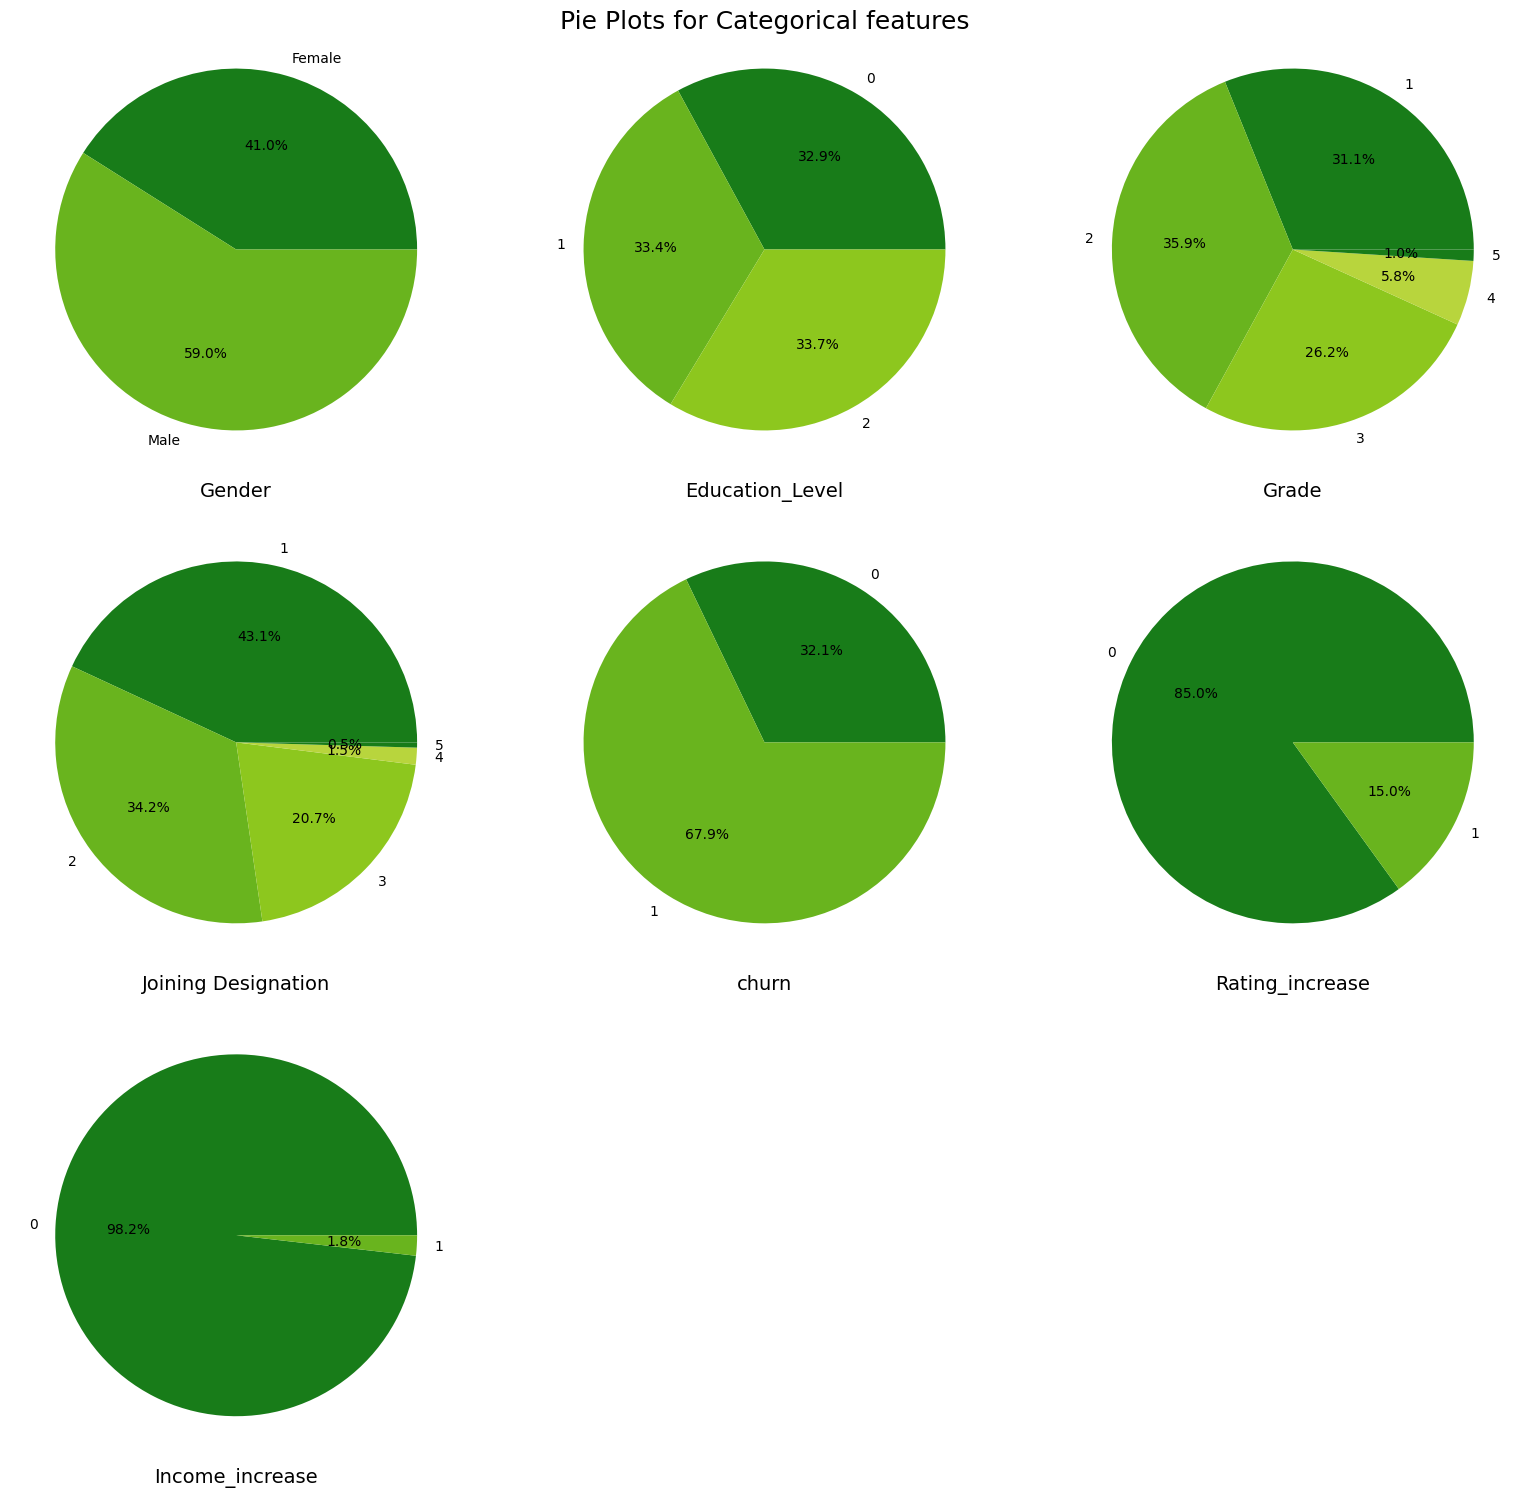

In [50]:
# Pie Plots for Categorical features
plt.figure(figsize=(16,20))
for i, elem in enumerate(req_cat_col_plot):
  plt.subplot(4,3,i+1)
  labels = df.groupby(elem)[elem].count().index.categories
  plt.pie(df.groupby(elem)[elem].count().values, labels = labels, autopct = "%1.1f%%", colors=green_palette)
  plt.xlabel(elem, fontsize=14)

plt.suptitle("Pie Plots for Categorical features", fontsize = 18)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of City')

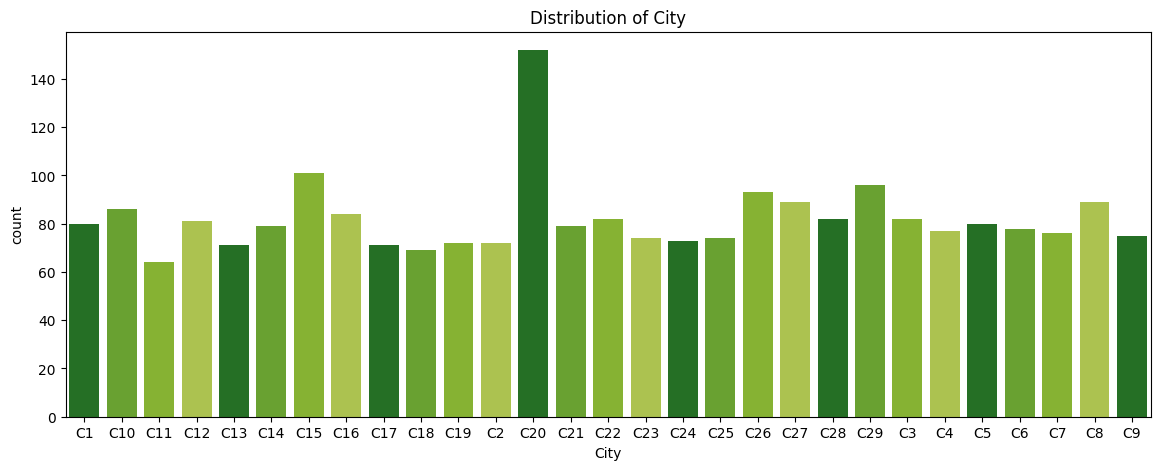

In [51]:
plt.figure(figsize=(14,5))
sns.countplot(x=df['City'], palette = green_palette)
plt.title('Distribution of City')

**🔍OBSERVATION🔎**

1. **Gender**:  
   - The majority of drivers are **Male (58.97%)**.

2. **City**:  
   - The most common city is **C20 (6.38%)**.

3. **Education Level**:  
   - The most frequent education level is **2 (33.68%)**, which could indicate a moderate educational background.

4. **Grade**:  
   - The most prevalent grade is **Grade 2 (35.91%)**, representing a significant portion of drivers.

5. **Joining Designation**:  
   - Most drivers started with **Joining Designation 1 (43.09%)**.

6. **Churn**:  
   - The churn rate is high, with **67.87% of drivers leaving**.

7. **Rating Increase**:  
   - A majority of drivers (**84.96%**) did not experience a rating increase.

8. **Income Increase**:  
   - Almost all drivers (**98.19%**) did not receive an income increase.

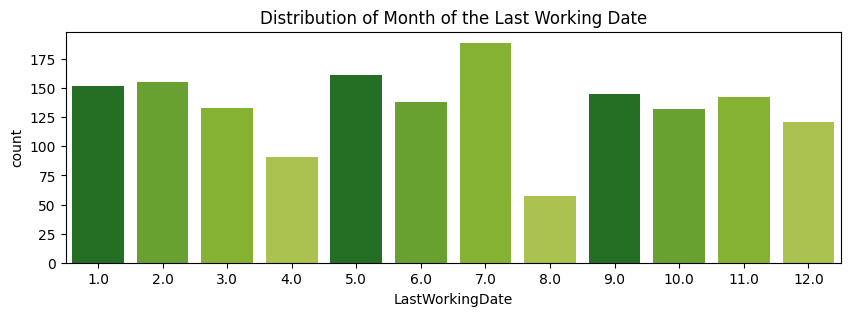

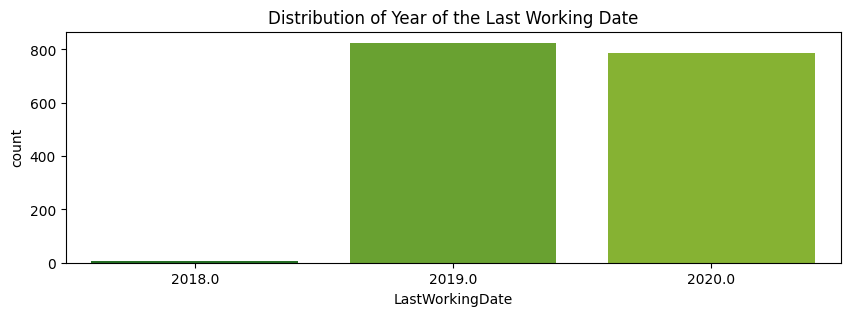

In [52]:
plt.figure(figsize=(10,3))
sns.countplot(x=df['LastWorkingDate'].dt.month, palette = green_palette)
plt.title('Distribution of Month of the Last Working Date')

plt.figure(figsize=(10,3))
sns.countplot(x=df['LastWorkingDate'].dt.year, palette = green_palette)
plt.title('Distribution of Year of the Last Working Date')

plt.show()

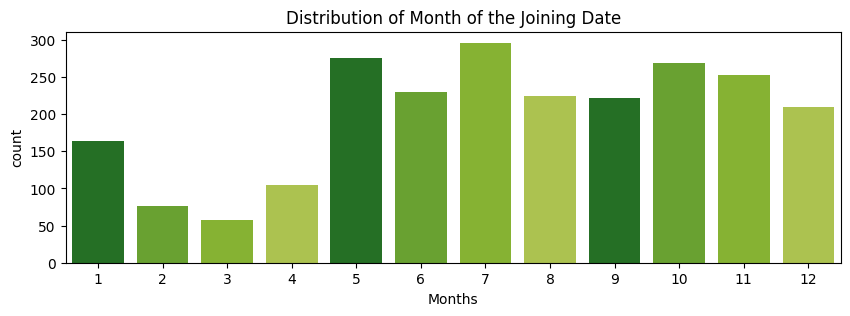

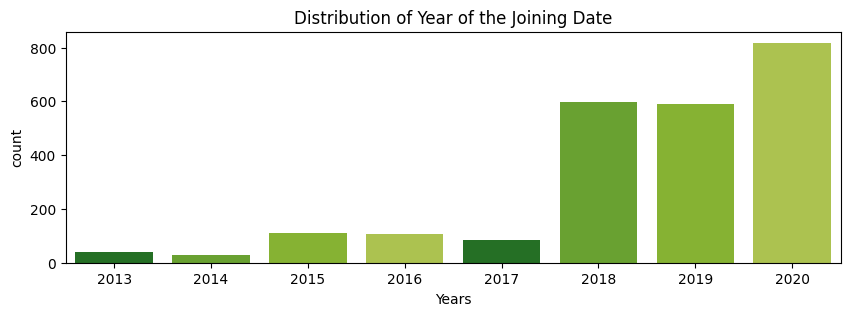

In [53]:
plt.figure(figsize=(10,3))
sns.countplot(x=df['Dateofjoining'].dt.month, palette = green_palette)
plt.title('Distribution of Month of the Joining Date')
plt.xlabel('Months')

plt.figure(figsize=(10,3))
sns.countplot(x=df['Dateofjoining'].dt.year, palette = green_palette)
plt.title('Distribution of Year of the Joining Date')
plt.xlabel('Years')

plt.show()

In [54]:
df.columns

Index(['Reportings', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Dateofjoining', 'LastWorkingDate', 'Grade', 'Total Business Value',
       'Income', 'Joining Designation', 'Quarterly Rating', 'churn',
       'Rating_increase', 'Income_increase'],
      dtype='object')

In [55]:
df.Age.dtype

dtype('int64')

In [56]:
df.select_dtypes(include=['int32','int64','float64'])

Reportings  Driver_ID  Age  Total Business Value  Income  \
0              3          1   28               1715580   57387   
1              2          2   31                     0   67016   
2              5          4   43                350000   65603   
3              3          5   29                120360   46368   
4              5          6   31               1265000   78728   
...          ...        ...  ...                   ...     ...   
2376          24       2784   34              21748820   82815   
2377           3       2785   34                     0   12105   
2378           9       2786   45               2815090   35370   
2379           6       2787   28                977830   69498   
2380           7       2788   30               2298240   70254   

      Quarterly Rating  
0                  2.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.6  
...                ...  
2376               2.6  
2377               1.0  
2378               1.7  
2379               1.5  
2380               2.3  

[2381 rows x 6 columns]

In [57]:
# Selecting the categorical columns
numerical_df = df.select_dtypes(include=['int32','int64','float64'])
numerical_df_req = numerical_df[['Reportings', 'Age', 'Total Business Value', 'Income', 'Quarterly Rating']] #numerical_df[numerical_df.columns[1:]]
numerical_df_req.columns

Index(['Reportings', 'Age', 'Total Business Value', 'Income',
       'Quarterly Rating'],
      dtype='object')

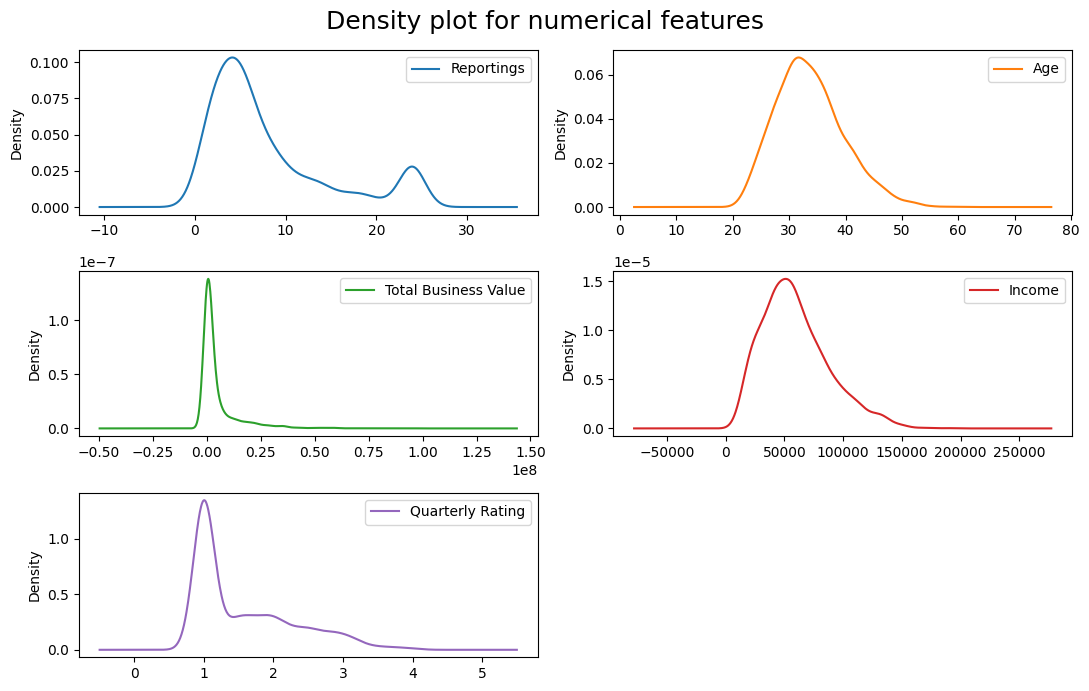

In [58]:
# Density plot for numerical columns
plt.rcParams["figure.figsize"] = [11,7]
numerical_df_req.plot(kind="density", subplots = True, layout = (3,2), sharex = False)
plt.suptitle("Density plot for numerical features", fontsize = 18)
plt.tight_layout()
plt.show()

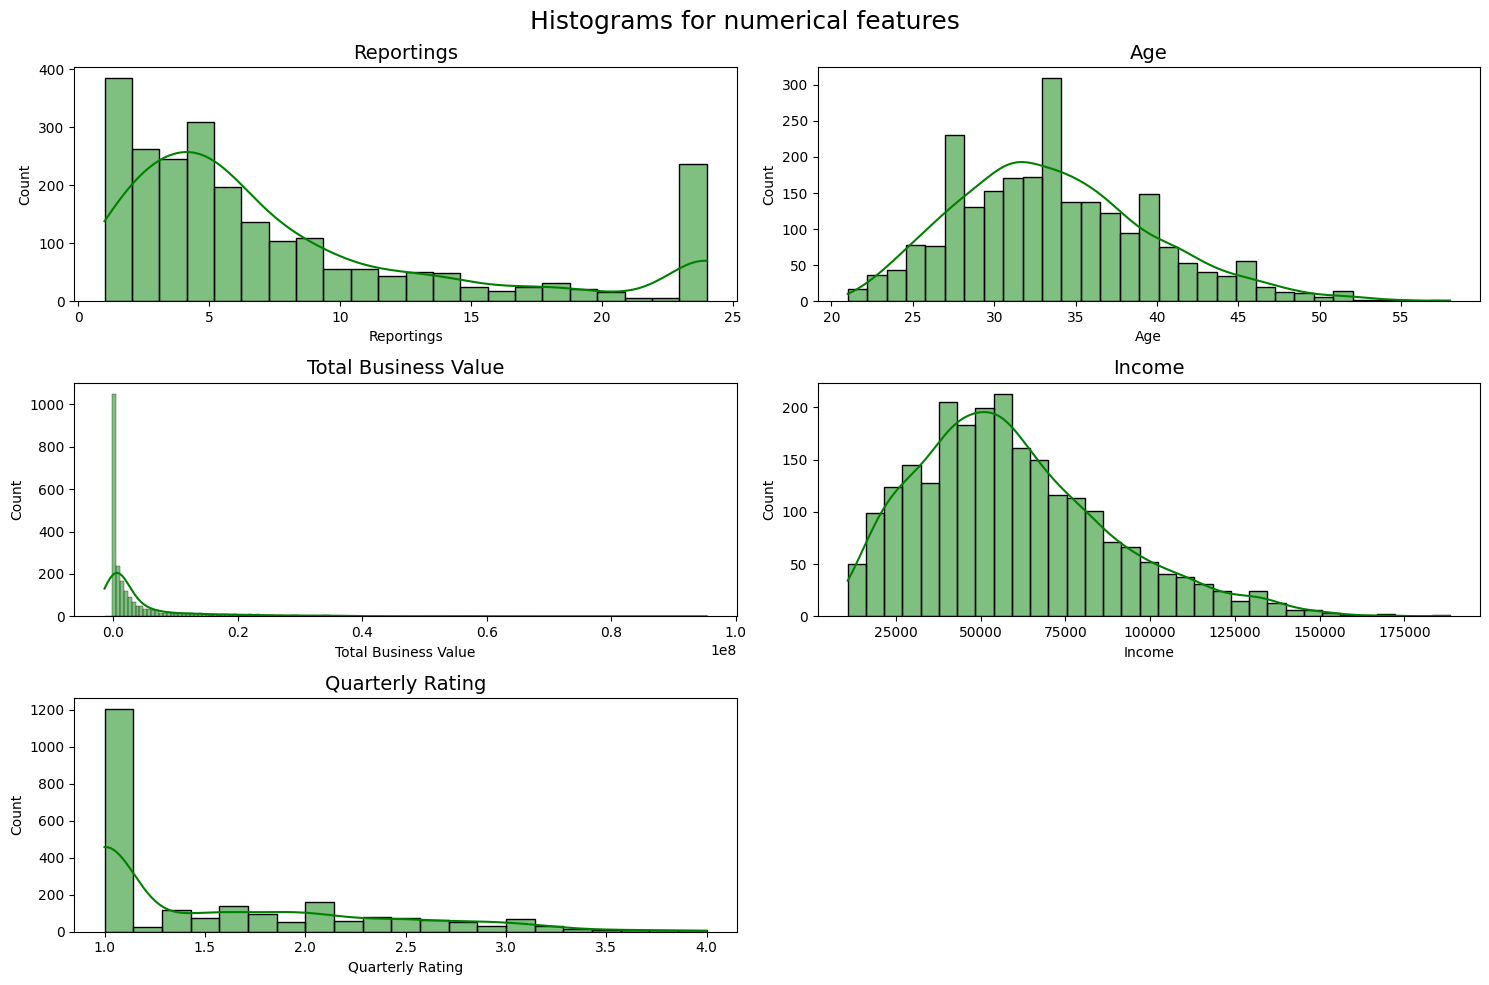

In [59]:
# Histograms for numerical columns
numerical_cols = numerical_df_req.columns

plt.figure(figsize=(15,10))
for i, elem in enumerate(numerical_cols):
  plt.subplot(3,2,i+1)
  sns.histplot(df[elem], kde=True, color='green')
  plt.title(elem, fontsize=14)

plt.suptitle("Histograms for numerical features", fontsize = 18)
plt.tight_layout()
plt.show()

In [60]:
# Skewness Coefficient:
print("Skewness Coefficient")
print("-" * 20)
print(numerical_df_req.skew().round(4))

Skewness Coefficient
--------------------
Reportings              1.2970
Age                     0.5391
Total Business Value    3.3613
Income                  0.7795
Quarterly Rating        1.0882
dtype: float64


**🔍OBSERVATION🔎**

1. **Reportings**: Skewed positively with a skewness of **1.2970**, indicating a longer tail on the right side.  
2. **Age**: Slightly positively skewed with a skewness of **0.5391**, showing a near-normal distribution.  
3. **Total Business Value**: Highly positively skewed with a skewness of **3.3613**, suggesting a strong concentration of lower values.  
4. **Income**: Positively skewed with a skewness of **0.7795**, indicating a moderate tail of higher income values.  
5. **Quarterly Rating**: Positively skewed with a skewness of **1.0882**, reflecting more drivers with lower ratings.

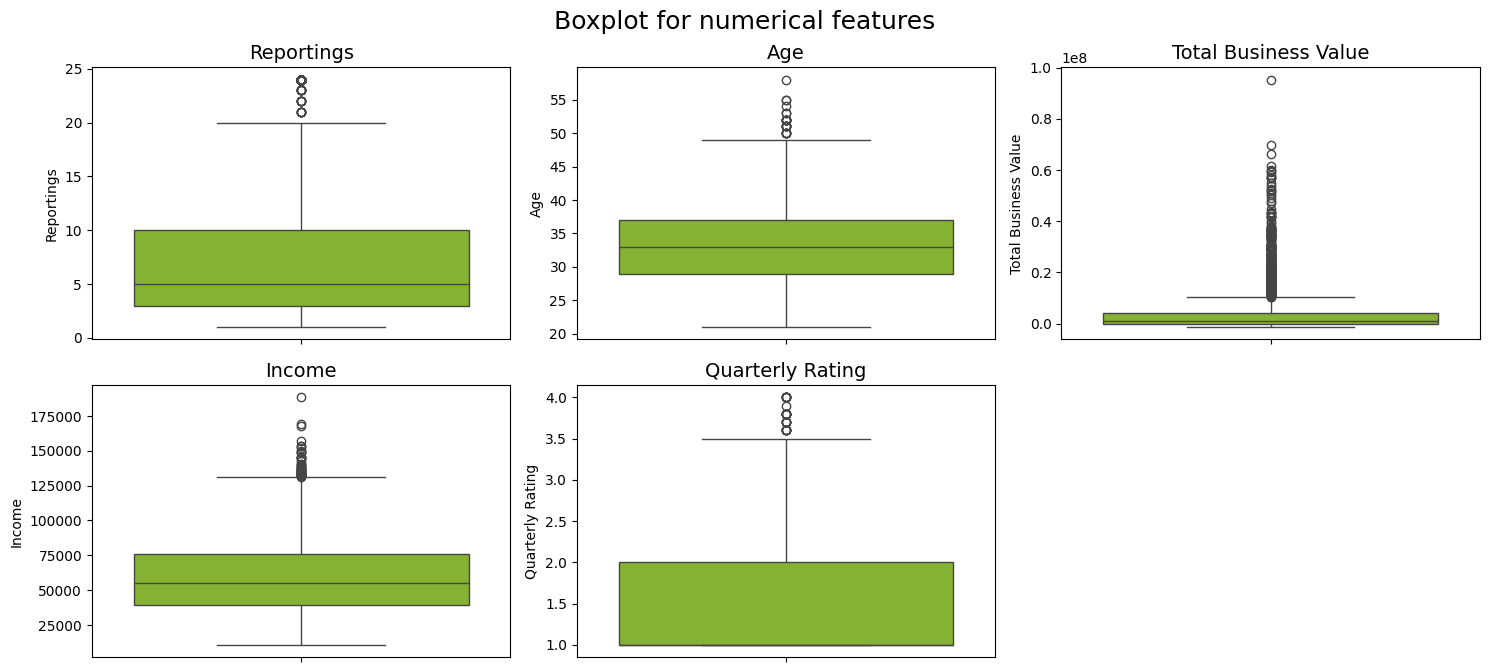

In [61]:
# Box plots for numerical columns
green = ['#8dc71e']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(df[col],palette = green)
    plt.title(col, fontsize=14)

plt.suptitle("Boxplot for numerical features", fontsize = 18)
plt.tight_layout()
plt.show()

### Multivariate Analysis

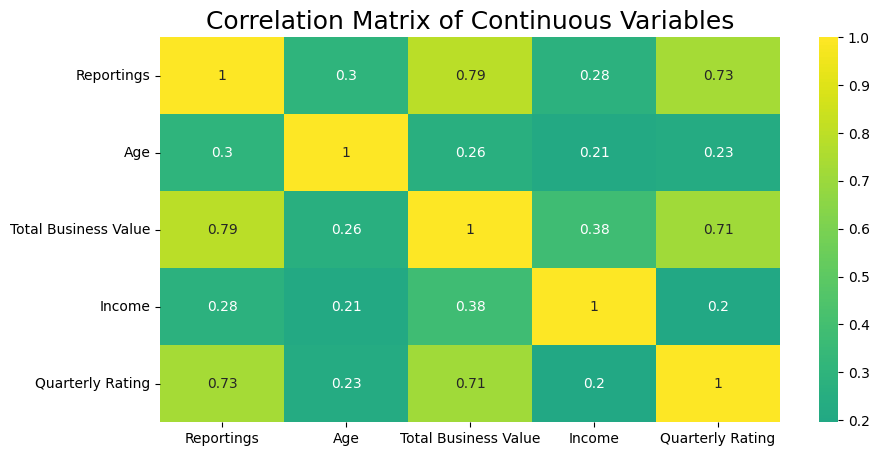

In [62]:
# Correlation Matrix of Continuous Variables
corr_matrix = numerical_df[numerical_cols].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', center=0)
plt.title('Correlation Matrix of Continuous Variables', fontsize = 18)
plt.yticks(rotation=360)
plt.show()

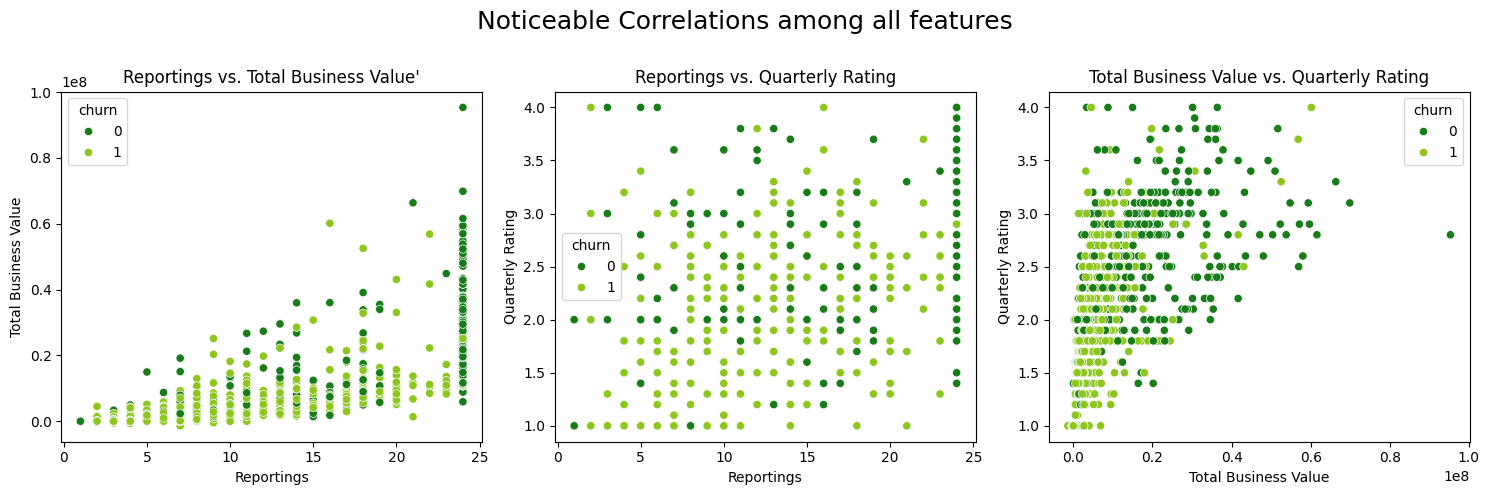

In [63]:
req_palette = ['#187c19', '#8dc71e']
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='Reportings', y='Total Business Value', hue='churn', data=df, palette=req_palette)
plt.title("Reportings vs. Total Business Value'")

plt.subplot(1, 3, 2)
sns.scatterplot(x='Reportings', y='Quarterly Rating', hue='churn', data=df, palette=req_palette)
plt.title("Reportings vs. Quarterly Rating")

plt.subplot(1, 3, 3)
sns.scatterplot(x='Total Business Value', y='Quarterly Rating', hue='churn', data=df, palette=req_palette)
plt.title("Total Business Value vs. Quarterly Rating")

plt.suptitle("Noticeable Correlations among all features", fontsize = 18)
plt.tight_layout()
plt.show()

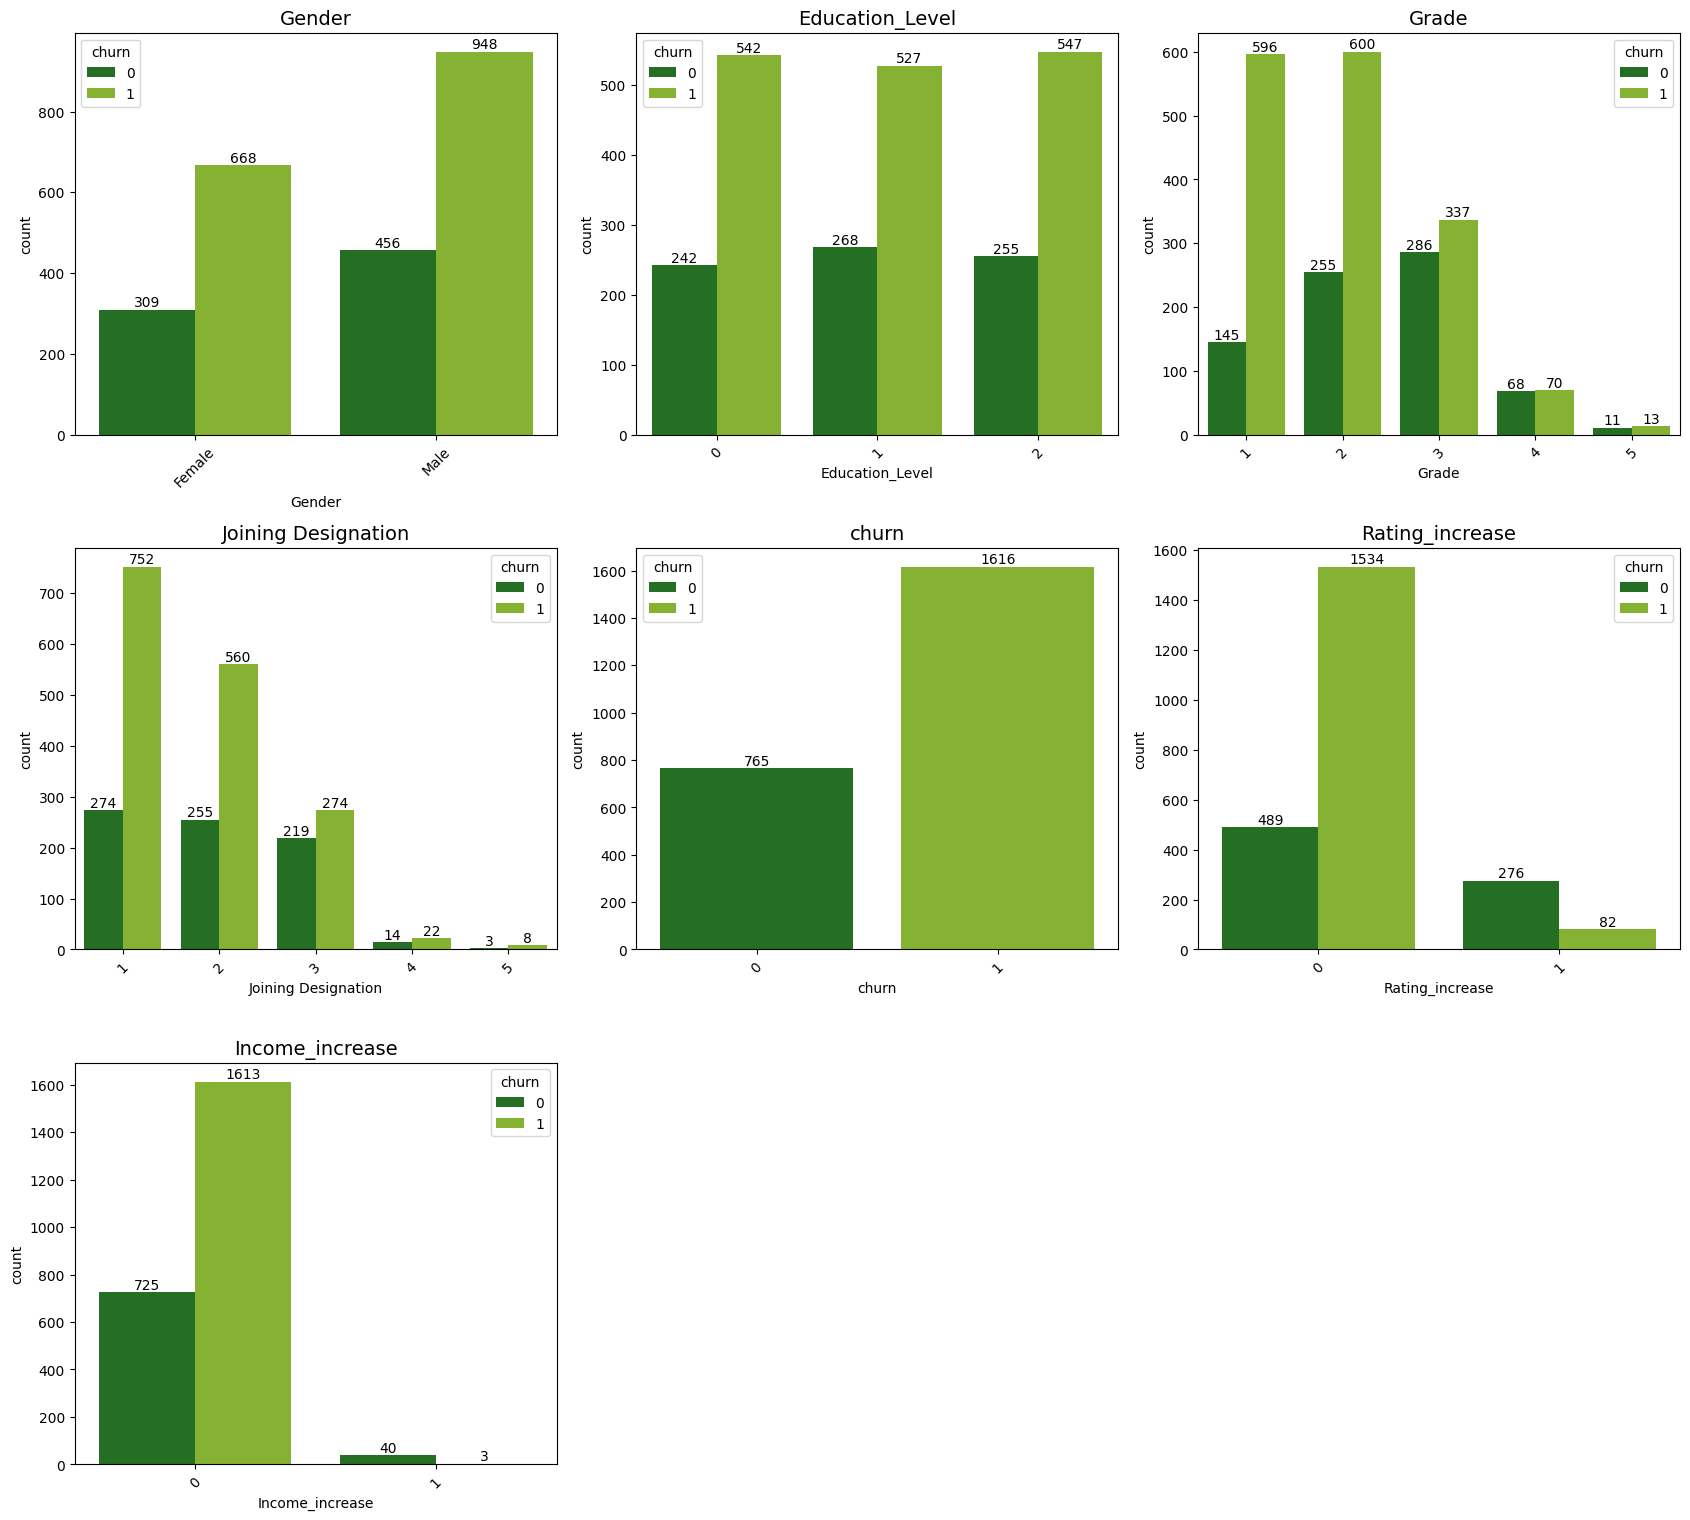

In [64]:
# Count Plots for Categorical features
req_cat_col_plot = ['Gender', 'Education_Level', 'Grade', 'Joining Designation','churn', 'Rating_increase', 'Income_increase']

plt.figure(figsize=(17,20))
for i, elem in enumerate(req_cat_col_plot):
  plt.subplot(4,3,i+1)
  label = sns.countplot(data = df, x = elem, hue='churn', palette = req_palette)
  for i in label.containers:
    label.bar_label(i)

  plt.xticks(rotation = 45)
  plt.ylabel('count')
  plt.title(elem, fontsize=14)

#plt.suptitle("Count Plots for Categorical features", fontsize = 18)
plt.tight_layout()
plt.show()

In [65]:
# Comparisons of Median values of all numerical features by loan status
print("Comparisons of Median values of all numerical features by loan status")
print("-" * 72)

for elem in numerical_cols:
  print(f"Column Name: {elem}")
  print(df.groupby('churn')[elem].median())
  print("_" * 35)
  print()

Comparisons of Median values of all numerical features by loan status
------------------------------------------------------------------------
Column Name: Reportings
churn
0    7.0
1    5.0
Name: Reportings, dtype: float64
___________________________________

Column Name: Age
churn
0    34.0
1    33.0
Name: Age, dtype: float64
___________________________________

Column Name: Total Business Value
churn
0    2636210.0
1     465025.0
Name: Total Business Value, dtype: float64
___________________________________

Column Name: Income
churn
0    64154.0
1    51630.0
Name: Income, dtype: float64
___________________________________

Column Name: Quarterly Rating
churn
0    2.0
1    1.0
Name: Quarterly Rating, dtype: float64
___________________________________



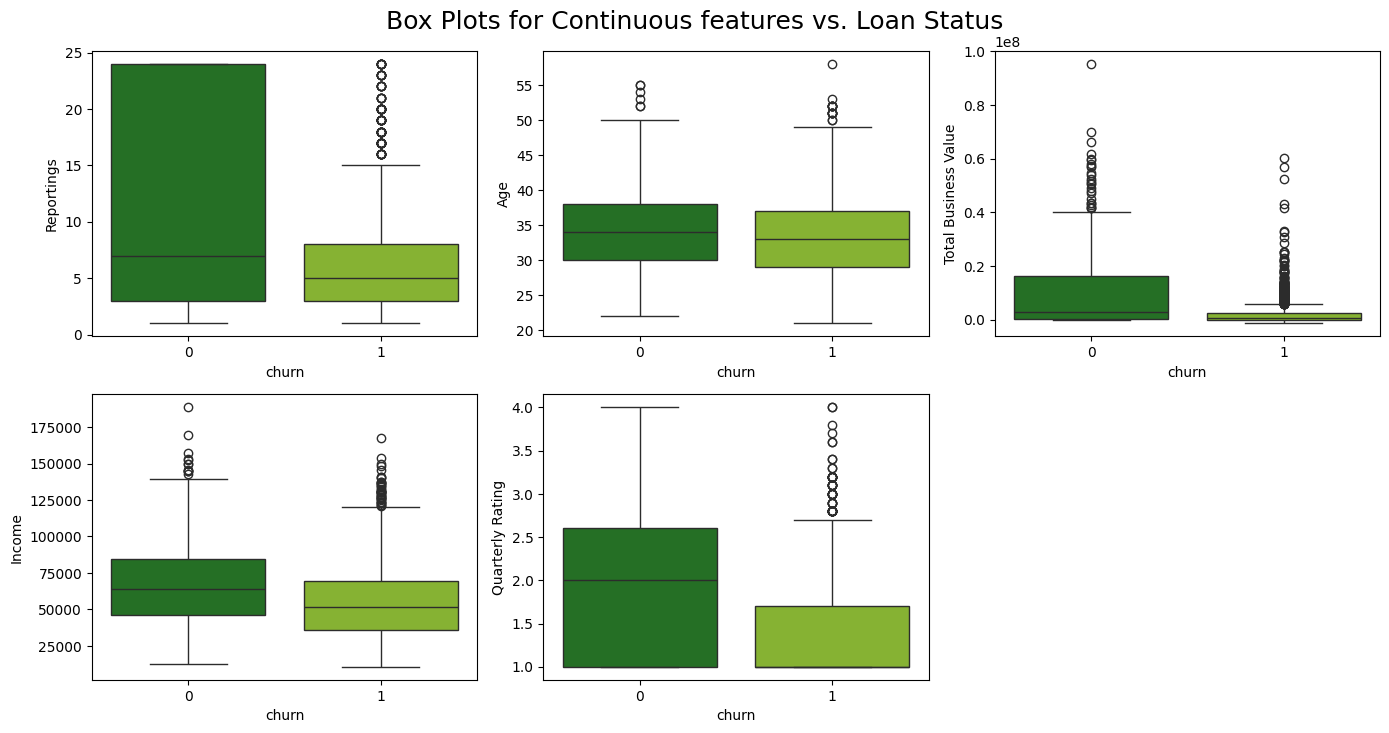

In [66]:
# Box Plots for Continuous features vs. Loan Status

plt.figure(figsize=(14, 14))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='churn', y=col, data=df, palette = req_palette)

plt.suptitle("Box Plots for Continuous features vs. Loan Status", fontsize = 18)
plt.tight_layout()
plt.show()

**🔍OBSERVATION🔎**

1. **Reportings**: Non-churned drivers have a higher median value (**7.0**) compared to churned drivers (**5.0**), indicating more reportings are linked to retention.  
2. **Age**: Non-churned drivers have a slightly higher median age (**34**) compared to churned drivers (**33**), suggesting age might have a minor influence.  
3. **Total Business Value**: Non-churned drivers have a significantly higher median total business value (**2,636,210**) than churned drivers (**465,025**), showing a strong correlation with retention.  
4. **Income**: Non-churned drivers have a higher median income (**64,154**) compared to churned drivers (**51,630**), suggesting better pay may reduce churn.  
5. **Quarterly Rating**: Non-churned drivers have a higher median quarterly rating (**2.0**) compared to churned drivers (**1.0**), indicating performance rating impacts churn behavior.  

### Churn Analysis

In [67]:
# Feature Engineering
df_churned = df[df['churn'] == 1]

In [68]:
df_churned['tenure_days'] = (df_churned['LastWorkingDate'] - df_churned['Dateofjoining']).apply(lambda x: x.days)

In [69]:
df_churned['Reporting_Rate'] = (df_churned['Reportings'] / df_churned['tenure_days'].replace(0, pd.NA)) * 100
df_churned['Reporting_Rate'] = df_churned['Reporting_Rate'].fillna(0)
df_churned['Reporting_Rate'] = df_churned['Reporting_Rate'].round(2)

In [70]:
df_churned.head()

Reportings  Driver_ID  Age Gender City Education_Level Dateofjoining  \
0           3          1   28   Male  C23               2    2018-12-24   
2           5          4   43   Male  C13               2    2019-12-07   
3           3          5   29   Male   C9               0    2019-01-09   
5           3          8   34   Male   C2               0    2020-09-19   
7           6         12   35   Male  C23               2    2019-06-29   

  LastWorkingDate Grade  Total Business Value  Income Joining Designation  \
0      2019-03-11     1               1715580   57387                   1   
2      2020-04-27     2                350000   65603                   2   
3      2019-03-07     1                120360   46368                   1   
5      2020-11-15     3                     0   70656                   3   
7      2019-12-21     1               2607180   28116                   1   

   Quarterly Rating churn Rating_increase Income_increase  tenure_days  \
0               2.0     1               0               0           77   
2               1.0     1               0               0          142   
3               1.0     1               0               0           57   
5               1.0     1               0               0           57   
7               2.5     1               0               0          175   

   Reporting_Rate  
0            3.90  
2            3.52  
3            5.26  
5            5.26  
7            3.43

In [71]:
# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(data=df_churned, x ='Reporting_Rate', bins=40, kde=True, color='green')
plt.title("Distribution of Reporting Rate")
plt.show()

In [72]:
df_churned['Reporting_Rate'].describe()

count    1616.000000
mean        3.155736
std         2.048271
min         0.000000
25%         1.600000
50%         3.470000
75%         4.092500
max        33.330000
Name: Reporting_Rate, dtype: float64

**🔍OBSERVATION🔎**

- The mean reporting rate for churned drivers is 3.16, indicating that, on average, churned drivers had moderate reporting rates before leaving.
- The median reporting rate is 3.47, which is close to the mean, indicating a relatively symmetric distribution for most churned drivers.
- The reporting rates vary widely, from a minimum of 0.00 to a maximum of 33.33, suggesting that while some churned drivers had no reports, a few had exceptionally high reporting rates.

## **Data preparation for modeling🔢**

In [73]:
# Creating a deep copy
df_model = df.copy()

In [74]:
df_model.drop(columns=['Driver_ID', 'LastWorkingDate'], inplace=True)
df_model['Month_of_joining'] = df_model['Dateofjoining'].dt.month
df_model['Year_of_joining']= df_model['Dateofjoining'].dt.year
df_model.drop(columns='Dateofjoining', inplace=True)

In [75]:
df_model.head()

Reportings  Age  Gender City Education_Level Grade  Total Business Value  \
0           3   28    Male  C23               2     1               1715580   
1           2   31    Male   C7               2     2                     0   
2           5   43    Male  C13               2     2                350000   
3           3   29    Male   C9               0     1                120360   
4           5   31  Female  C11               1     3               1265000   

   Income Joining Designation  Quarterly Rating churn Rating_increase  \
0   57387                   1               2.0     1               0   
1   67016                   2               1.0     0               0   
2   65603                   2               1.0     1               0   
3   46368                   1               1.0     1               0   
4   78728                   3               1.6     0               1   

  Income_increase  Month_of_joining  Year_of_joining  
0               0                12             2018  
1               0                11             2020  
2               0                12             2019  
3               0                 1             2019  
4               0                 7             2020

In [76]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Reportings            2381 non-null   int64   
 1   Age                   2381 non-null   int64   
 2   Gender                2381 non-null   category
 3   City                  2381 non-null   category
 4   Education_Level       2381 non-null   category
 5   Grade                 2381 non-null   category
 6   Total Business Value  2381 non-null   int64   
 7   Income                2381 non-null   int64   
 8   Joining Designation   2381 non-null   category
 9   Quarterly Rating      2381 non-null   float64 
 10  churn                 2381 non-null   category
 11  Rating_increase       2381 non-null   category
 12  Income_increase       2381 non-null   category
 13  Month_of_joining      2381 non-null   int32   
 14  Year_of_joining       2381 non-null   int32   
dtypes: c

In [77]:
df_model_category_columns = df_model.select_dtypes(include='category')
df_model_category_columns.head()

Gender City Education_Level Grade Joining Designation churn  \
0    Male  C23               2     1                   1     1   
1    Male   C7               2     2                   2     0   
2    Male  C13               2     2                   2     1   
3    Male   C9               0     1                   1     1   
4  Female  C11               1     3                   3     0   

  Rating_increase Income_increase  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               1               0

### Label Encoding

In [78]:
# Convert the following columns directly to int since they are ordinal
columns = ['Education_Level', 'Grade', 'Joining Designation', 'churn', 'Rating_increase', 'Income_increase']

for cols in columns:
  df_model[cols] = df_model[cols].astype('int')

In [79]:
# Encode (Male = 0, Female = 1)
df_model['Gender'] = df_model['Gender'].map({"Male": 0, "Female": 1})
df_model['Gender'] = df_model['Gender'].astype('int')

In [80]:
df_model['City'].nunique(), df_model['City'].unique()

(29,
 ['C23', 'C7', 'C13', 'C9', 'C11', ..., 'C4', 'C3', 'C16', 'C22', 'C12']
 Length: 29
 Categories (29, object): ['C1', 'C10', 'C11', 'C12', ..., 'C6', 'C7', 'C8', 'C9'])

### One Hot Encodeing

In [81]:
# Perform one-hot encoding for 'City' column and drop the first category
df_encoded = pd.get_dummies(df_model, columns=['City'], prefix='City', drop_first=True)*1

In [82]:
df_encoded.head()

Reportings  Age  Gender  Education_Level  Grade  Total Business Value  \
0           3   28       0                2      1               1715580   
1           2   31       0                2      2                     0   
2           5   43       0                2      2                350000   
3           3   29       0                0      1                120360   
4           5   31       1                1      3               1265000   

   Income  Joining Designation  Quarterly Rating  churn  Rating_increase  \
0   57387                    1               2.0      1                0   
1   67016                    2               1.0      0                0   
2   65603                    2               1.0      1                0   
3   46368                    1               1.0      1                0   
4   78728                    3               1.6      0                1   

   Income_increase  Month_of_joining  Year_of_joining  City_C10  City_C11  \
0                0                12             2018         0         0   
1                0                11             2020         0         0   
2                0                12             2019         0         0   
3                0                 1             2019         0         0   
4                0                 7             2020         0         1   

   City_C12  City_C13  City_C14  City_C15  City_C16  City_C17  City_C18  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   City_C19  City_C2  City_C20  City_C21  City_C22  City_C23  City_C24  \
0         0        0         0         0         0         1         0   
1         0        0         0         0         0         0         0   
2         0        0         0         0         0         0         0   
3         0        0         0         0         0         0         0   
4         0        0         0         0         0         0         0   

   City_C25  City_C26  City_C27  City_C28  City_C29  City_C3  City_C4  \
0         0         0         0         0         0        0        0   
1         0         0         0         0         0        0        0   
2         0         0         0         0         0        0        0   
3         0         0         0         0         0        0        0   
4         0         0         0         0         0        0        0   

   City_C5  City_C6  City_C7  City_C8  City_C9  
0        0        0        0        0        0  
1        0        0        1        0        0  
2        0        0        0        0        0  
3        0        0        0        0        1  
4        0        0        0        0        0

In [83]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Reportings            2381 non-null   int64  
 1   Age                   2381 non-null   int64  
 2   Gender                2381 non-null   int64  
 3   Education_Level       2381 non-null   int64  
 4   Grade                 2381 non-null   int64  
 5   Total Business Value  2381 non-null   int64  
 6   Income                2381 non-null   int64  
 7   Joining Designation   2381 non-null   int64  
 8   Quarterly Rating      2381 non-null   float64
 9   churn                 2381 non-null   int64  
 10  Rating_increase       2381 non-null   int64  
 11  Income_increase       2381 non-null   int64  
 12  Month_of_joining      2381 non-null   int32  
 13  Year_of_joining       2381 non-null   int32  
 14  City_C10              2381 non-null   int64  
 15  City_C11             

### Train Test Split

In [84]:
# Lets split the data into Independent feature and dependent feature
y = df_encoded['churn']
X = df_encoded.drop('churn', axis = 1)
X.shape, y.shape

((2381, 41), (2381,))

In [85]:
# Lets split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# After_train_test_split
# X_train | y_train
# X_test | y_test

### Scaling

**In general:**

- Bagging and Boosting with Decision Trees: No scaling required.
- Other weak learners (KNN, SVM, etc.) in Bagging/Boosting: Scaling is needed.

**Best Practices:** For Tree-Based Methods (Bagging/Boosting):
- Scaling is not necessary, but you can still standardize or normalize if you are preprocessing the dataset for consistency across models.

In [87]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [88]:
# After_train_test_split       After Scaling
# X_train | y_train  -->   X_train_scaled | y_train
# X_test | y_test    -->   X_test_scaled | y_test

### Handling Class Imbalance

In [89]:
print(((y_train.value_counts(normalize=True)) * 100).round(2))

churn
1    67.7
0    32.3
Name: proportion, dtype: float64


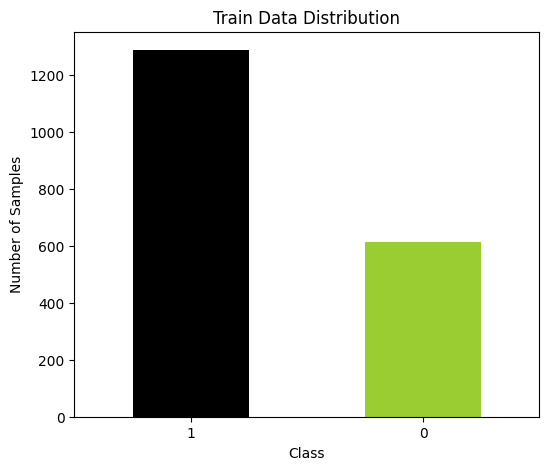

In [90]:
plt.figure(figsize=(6, 5))
y_train.value_counts().plot(kind='bar', color=['black', 'yellowgreen'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Train Data Distribution')
plt.xticks(rotation=0)
plt.show()

#### SMOTE

In [91]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE()

# Perform SMOTE on the training data
# Oversample the training data using SMOTE
X_train_balanced, y_train_balanced  = smote.fit_resample(X_train_scaled, y_train)

In [92]:
# After_train_test_split       After Scaling                     After SMOTE
# X_train | y_train  -->   X_train_scaled | y_train   -->   X_train_balanced | y_train_balanced
# X_test | y_test    -->   X_test_scaled | y_test     -->   X_test_scaled | y_test

In [93]:
print(((y_train_balanced.value_counts(normalize=True)) * 100).round(2))

churn
0    50.0
1    50.0
Name: proportion, dtype: float64


In [94]:
plt.figure(figsize=(6, 5))
y_train_balanced.value_counts().plot(kind='bar', color=['black', 'yellowgreen'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Train Data Distribution after SMOTE')
plt.xticks(rotation=0)
plt.show()



---


## **Model Building - Ensemble Learning💻**

### Bagging Random Forest Classifier

#### What is Bagging in Ensemble Learning?

Bagging (Bootstrap Aggregating) is an ensemble learning technique that combines predictions from multiple models (base estimators) to improve overall performance and reduce variance. The key idea is:

- **Bootstrap Sampling:** Random subsets of data are sampled with replacement to train each model.

- **Aggregation:** Predictions are averaged (for regression) or voted (for classification) to create the final prediction.
Example: Random Forest is a popular bagging algorithm that uses decision trees as base estimators.

**Advantages:**

- Reduces overfitting by combining weak learners.
- Improves model stability and accuracy.


#### Hyperparameter Tuning Using RandomizedSearchCV

Define hyperparameters to tune a bagging model (e.g., Random Forest).

These are the hyperparameters for a **Random Forest** model, which is a commonly used **Bagging algorithm**. Here’s what each hyperparameter represents:

- **`n_estimators`**: The number of trees in the forest.  

   
- **`max_depth`**: The maximum depth of each decision tree.  


- **`min_samples_split`**: The minimum number of samples required to split an internal node.  


- **`min_samples_leaf`**: The minimum number of samples required to be at a leaf node.  
  

- **`bootstrap`**: Whether to use bootstrap sampling (random sampling with replacement) when building trees.  




In [95]:
# Hyperparameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False]
}

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt

# Define the model
rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
                                    estimator=rf,
                                    param_distributions=param_dist,
                                    n_iter=50,
                                    scoring='roc_auc',
                                    cv=5,
                                    verbose=2,
                                    random_state=42,
                                    n_jobs=-1
                                  )

# Fit the model
start = dt.datetime.now()
random_search.fit(X_train_balanced, y_train_balanced)
end = dt.datetime.now()

# Best parameters
print("Best Parameters:", random_search.best_params_)
print("Best cross-validation score achieved: ", random_search.best_score_)
print(f"Time taken for RandomizedSearchCV(fits) : {end - start}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}
Best cross-validation score achieved:  0.9841618914139447
Time taken for RandomizedSearchCV(fits) : 0:05:15.726154


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Create the DataFrame from cv_results_
cv_results_df = pd.DataFrame(random_search.cv_results_)

# Sort by mean_test_score descending
cv_results_df = cv_results_df.sort_values(by='mean_test_score', ascending=False)

# Define top_n to display
top_n = 10
top_results = cv_results_df.head(top_n).copy()

# Convert hyperparameters dict to readable multiline string
top_results['param_str'] = top_results['params'].apply(
    lambda x: '\n'.join(f"{k}={v}" for k, v in x.items())
)

# Convert AUC scores to percentages
top_results['mean_test_score'] = top_results['mean_test_score'] * 100

# Set style and palette
sns.set(style="whitegrid")
# green_palette = sns.color_palette("Greens", n_colors=top_n)

# Plotting
fig, ax = plt.subplots(figsize=(18, 10))
bars = sns.barplot(
    y='param_str',
    x='mean_test_score',
    data=top_results,
    palette=green_palette[::-1],
    ax=ax
)

# Add labels inside bars
for container in bars.containers:
    bars.bar_label(container,
                   labels=[f"{v.get_width():.1f}%" for v in container],
                   label_type='center',
                   color='black',
                   fontsize=12,
                   weight='bold')

# Axis formatting
ax.set_xlabel("Mean AUC (Cross-Validation)", fontsize=13)
ax.set_ylabel("Hyperparameter Combination", fontsize=13)
ax.set_title(f"Top {top_n} Hyperparameter Sets by Cross-Validation AUC", fontsize=15)

# Format x-axis ticks as percentages
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Expand left margin
plt.subplots_adjust(left=0.4)
plt.tight_layout()
sns.despine()
plt.show()


In [98]:
tree = random_search.best_estimator_.estimators_[0]
tree

DecisionTreeClassifier(max_depth=30, max_features='sqrt',
                       random_state=1608637542)

In [99]:
from sklearn.tree import export_graphviz

for depth in [5, 10, 15, 20, 25, 30]:
    filename = f"tree_depth_{depth}.pdf"
    export_graphviz(tree,
                    out_file=filename,
                    feature_names=X_train_balanced.columns,
                    class_names=True,
                    max_depth=depth,
                    filled=True,
                    rounded=True)
    print(f"Exported tree to {filename}")


Exported tree to tree_depth_5.pdf
Exported tree to tree_depth_10.pdf
Exported tree to tree_depth_15.pdf
Exported tree to tree_depth_20.pdf
Exported tree to tree_depth_25.pdf
Exported tree to tree_depth_30.pdf


In [100]:
y_train_balanced = pd.Series(y_train_balanced)

In [101]:
# from dtreeviz import dtreeviz

# # Ensure y_train_balanced is a pandas Series or numpy array
# if not hasattr(y_train_balanced, "__iter__"):
#     raise ValueError("y_train_balanced must be an array-like object")

# # Create a list of class names based on unique classes in y_train_balanced
# class_labels = sorted(set(y_train_balanced))  # e.g., [0, 1]
# class_names = [str(label) for label in class_labels]

# # Visualize the decision tree
# viz = dtreeviz(
#     tree,
#     X_train_balanced,
#     y_train_balanced,
#     feature_names=X_train_balanced.columns.tolist(),
#     class_names=class_names,
#     fancy=True
# )

# viz.view()


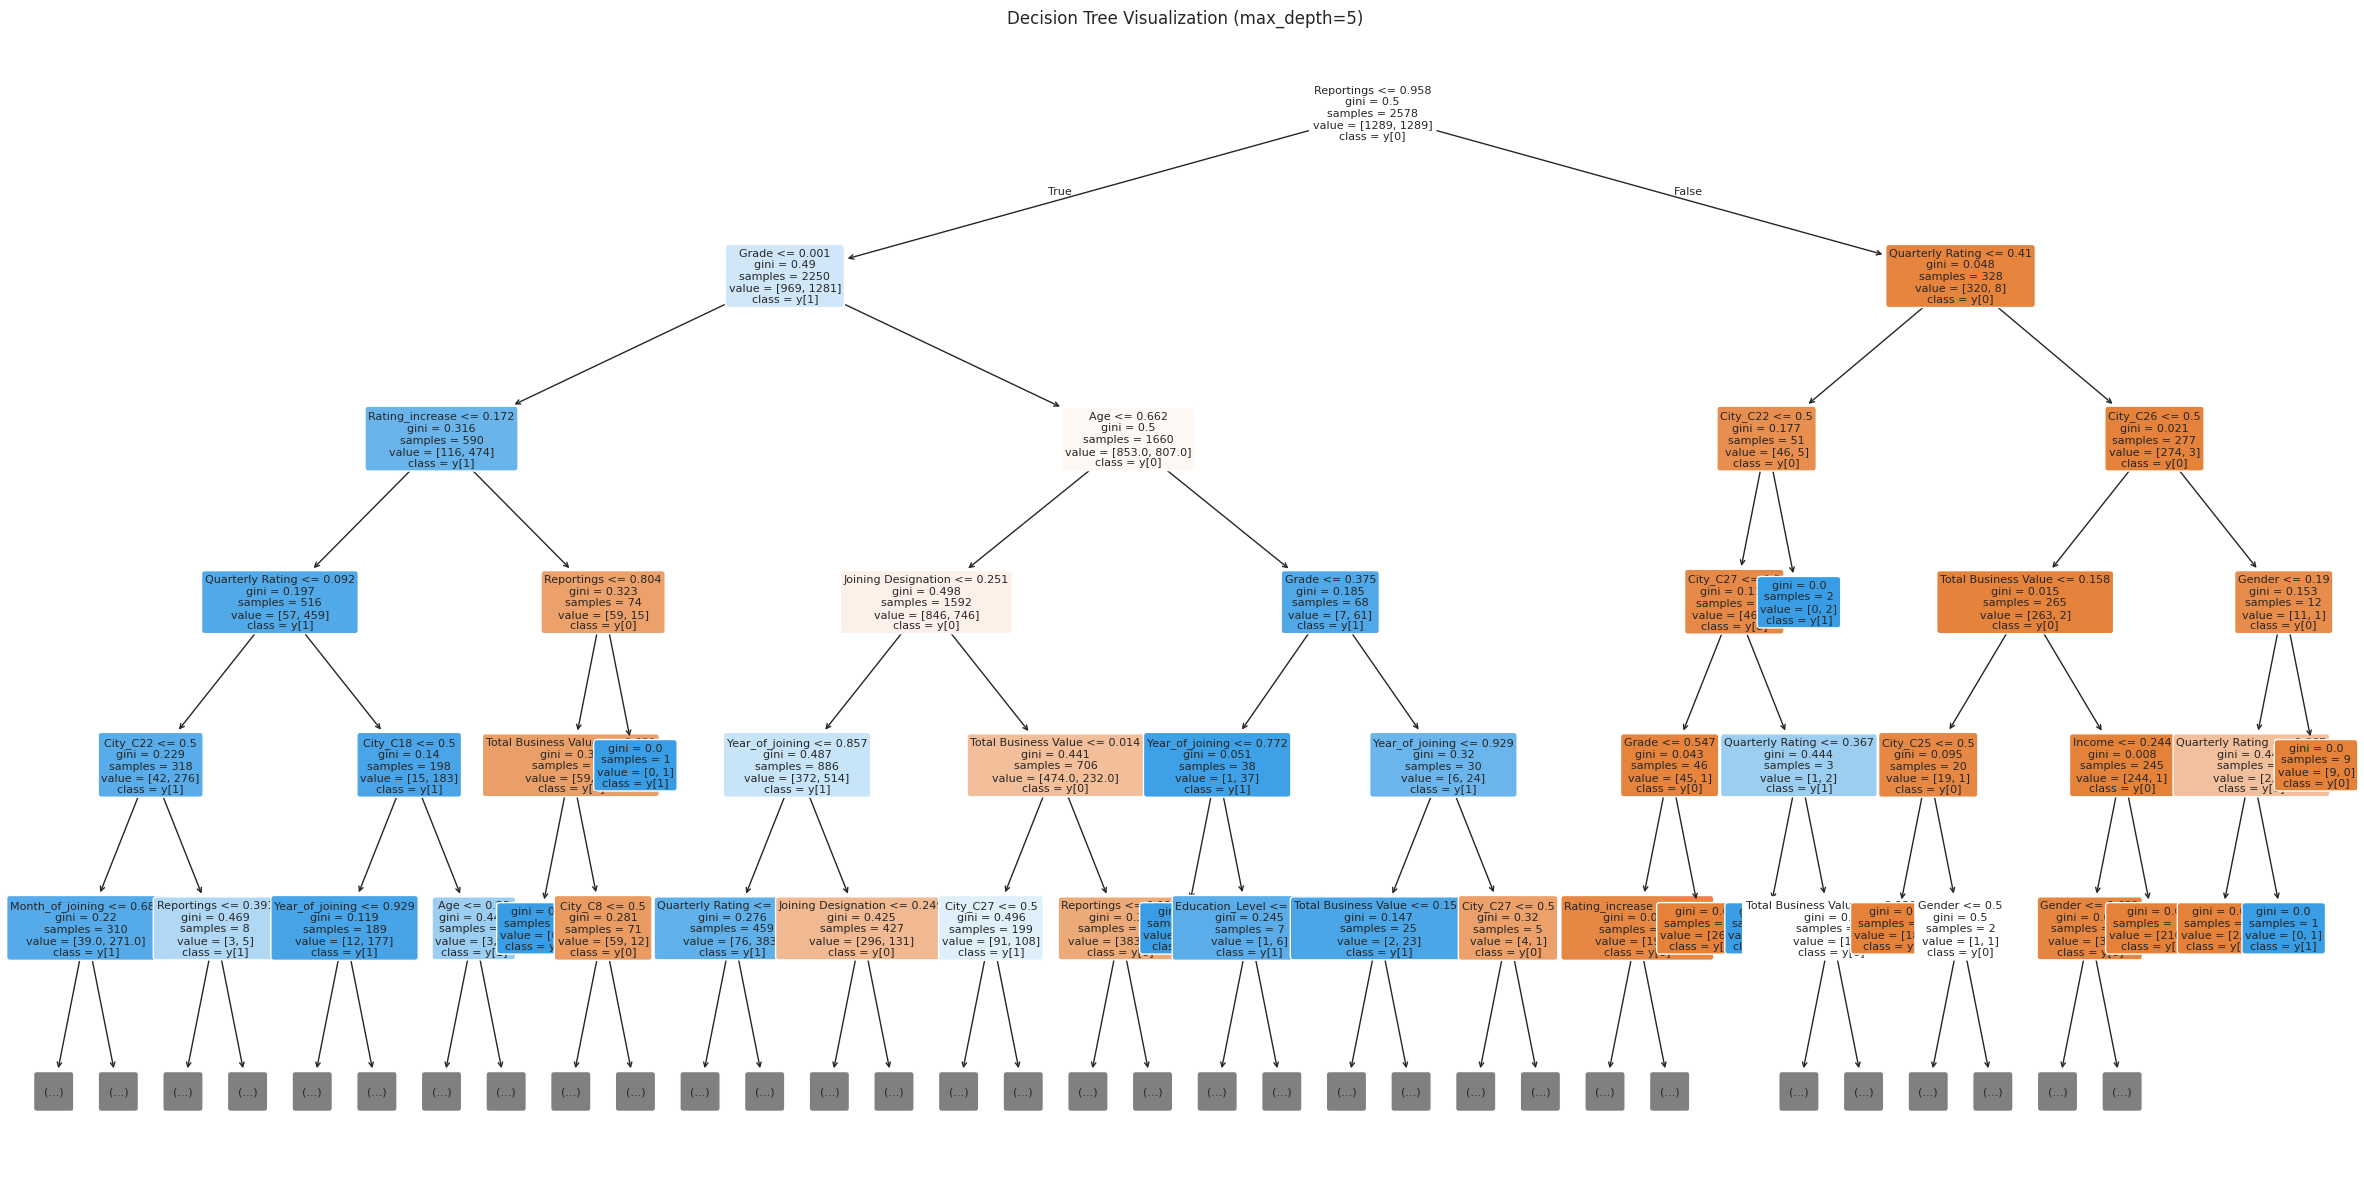

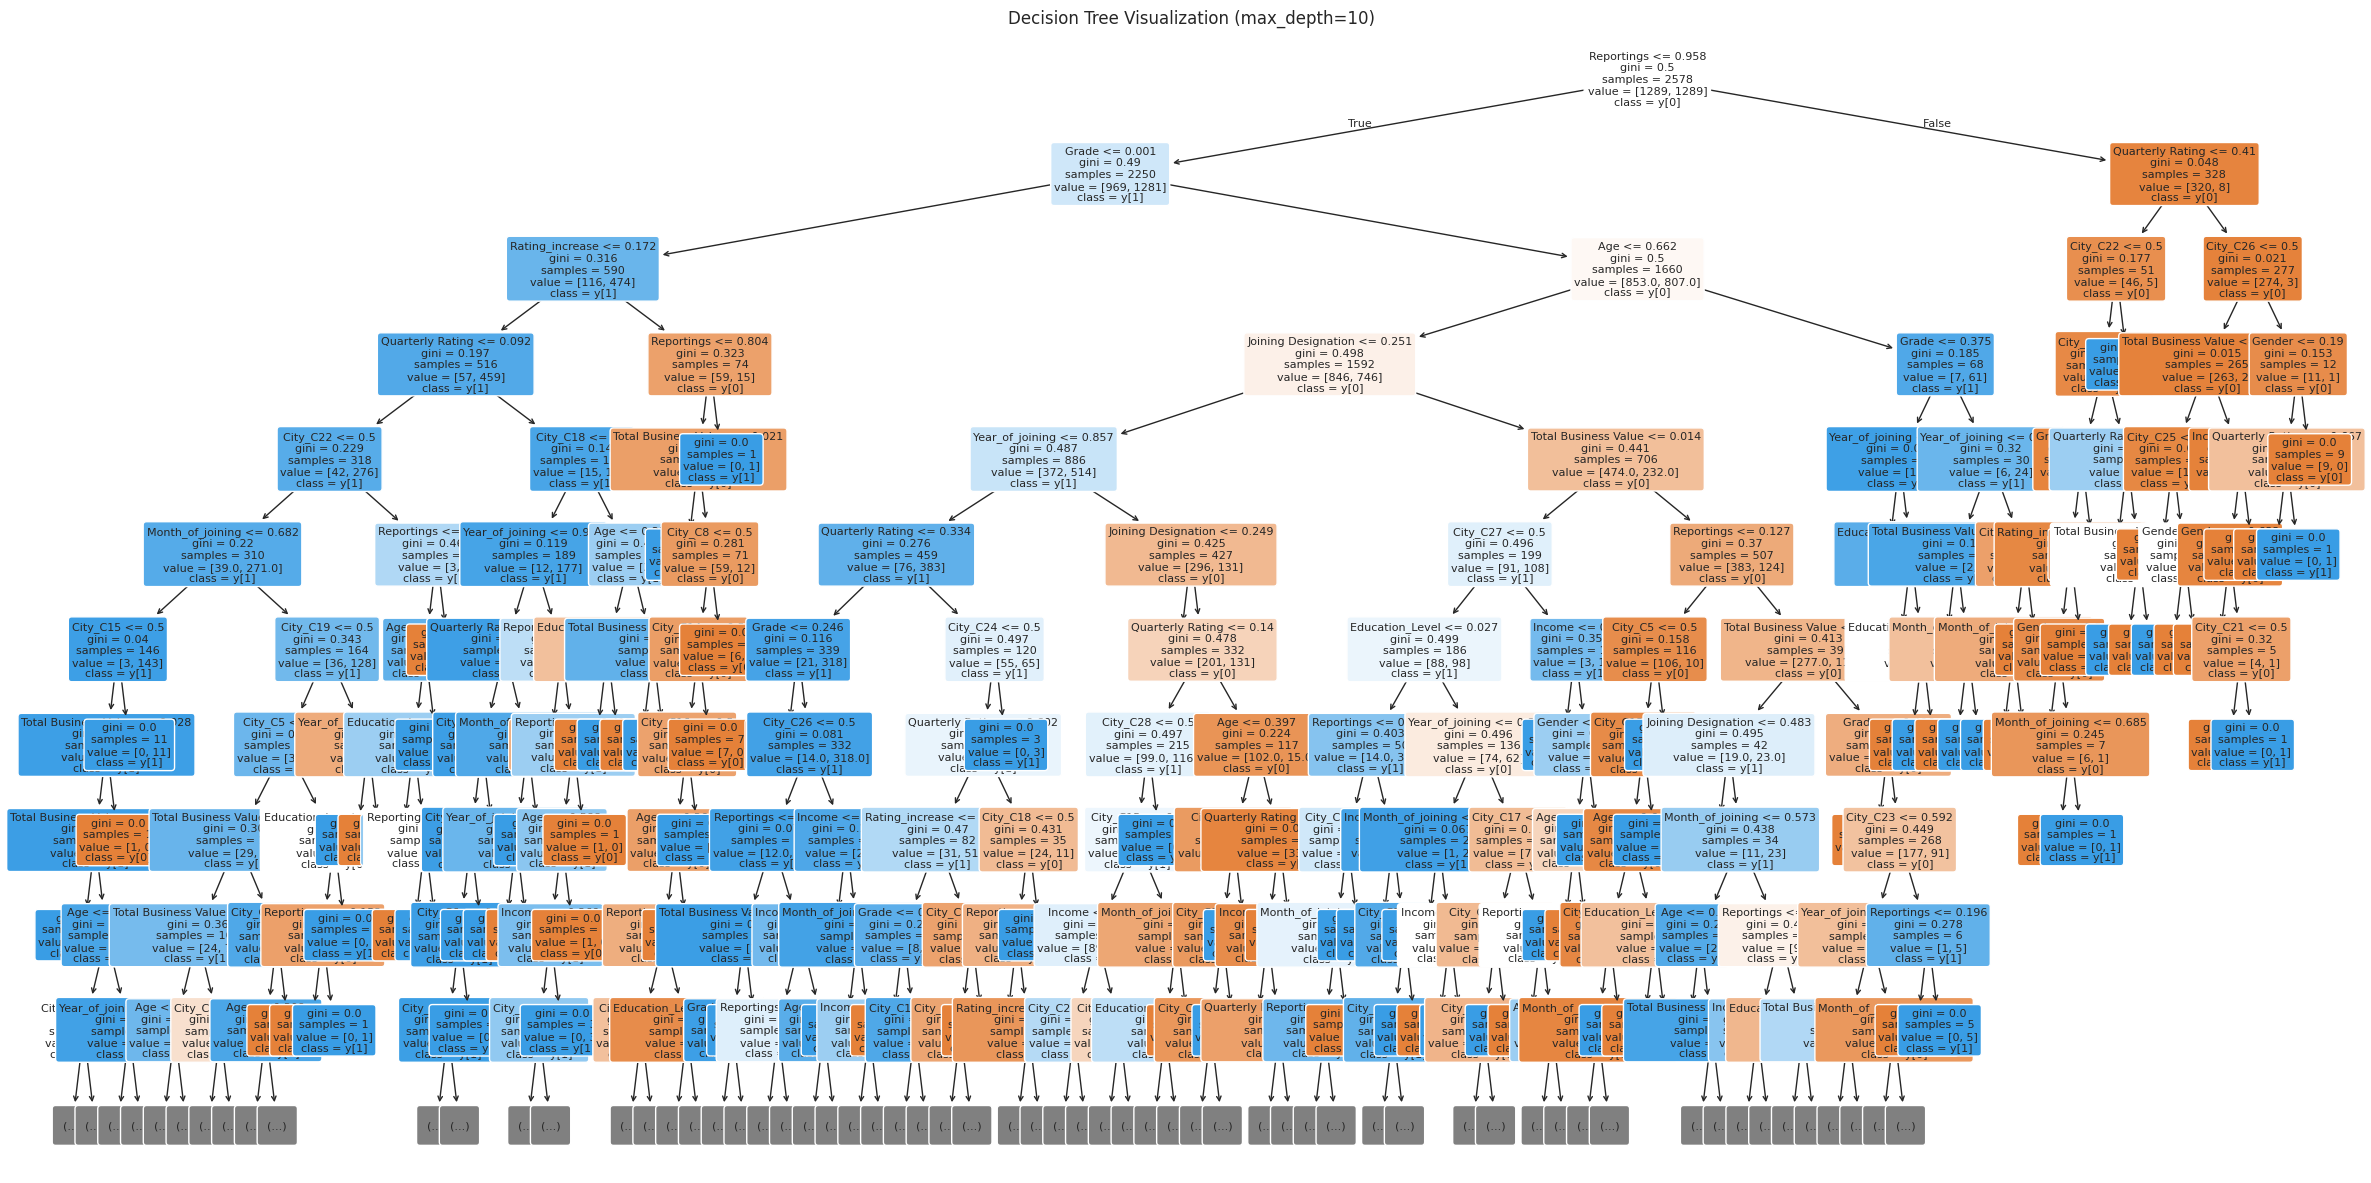

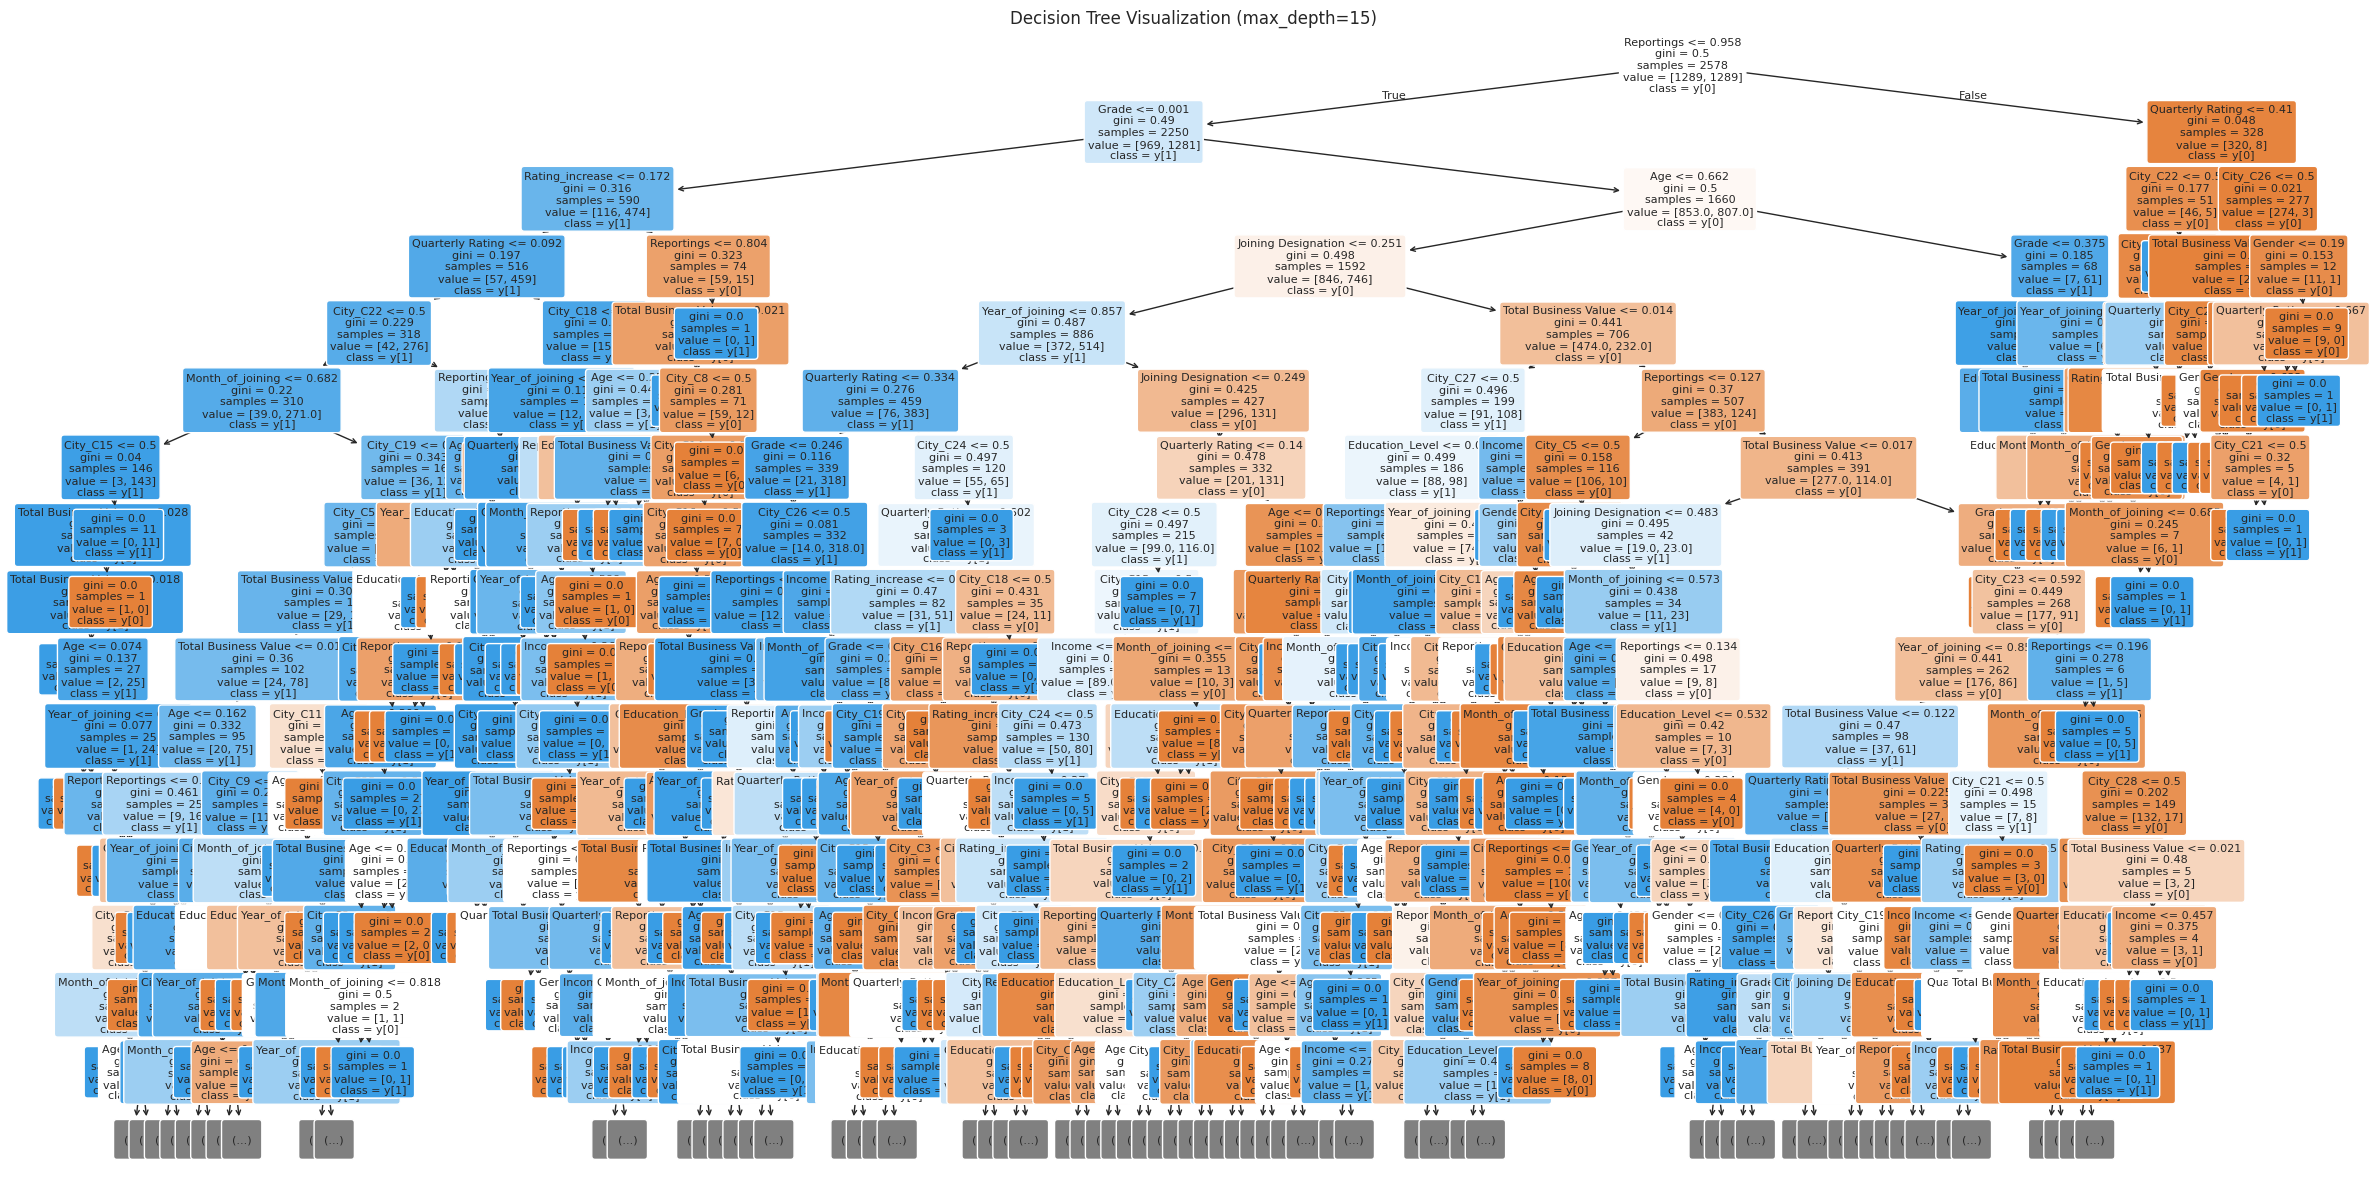

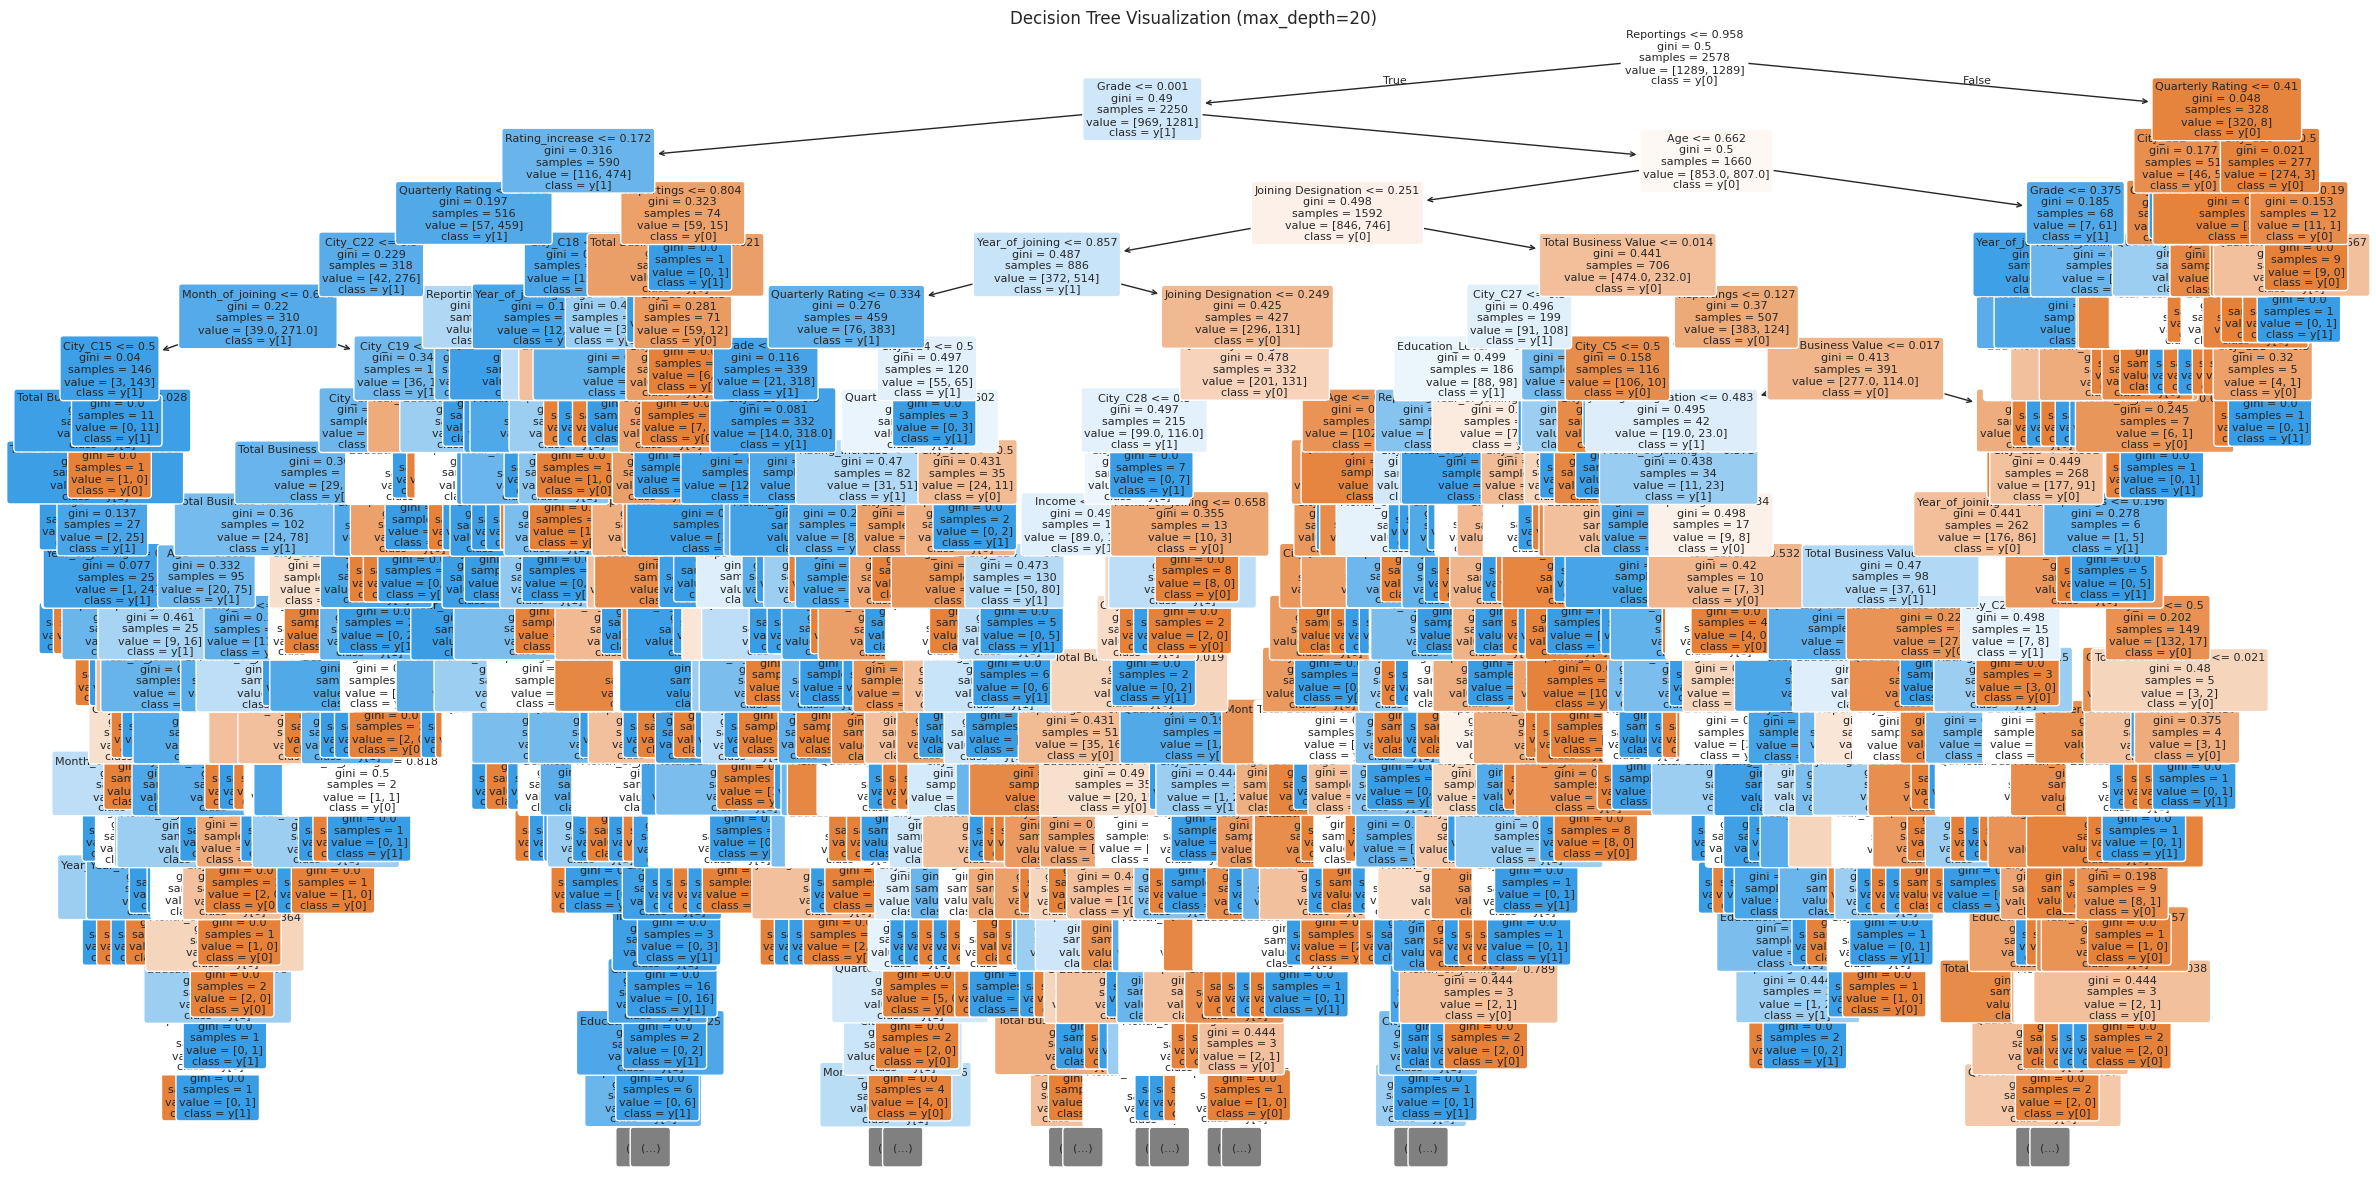

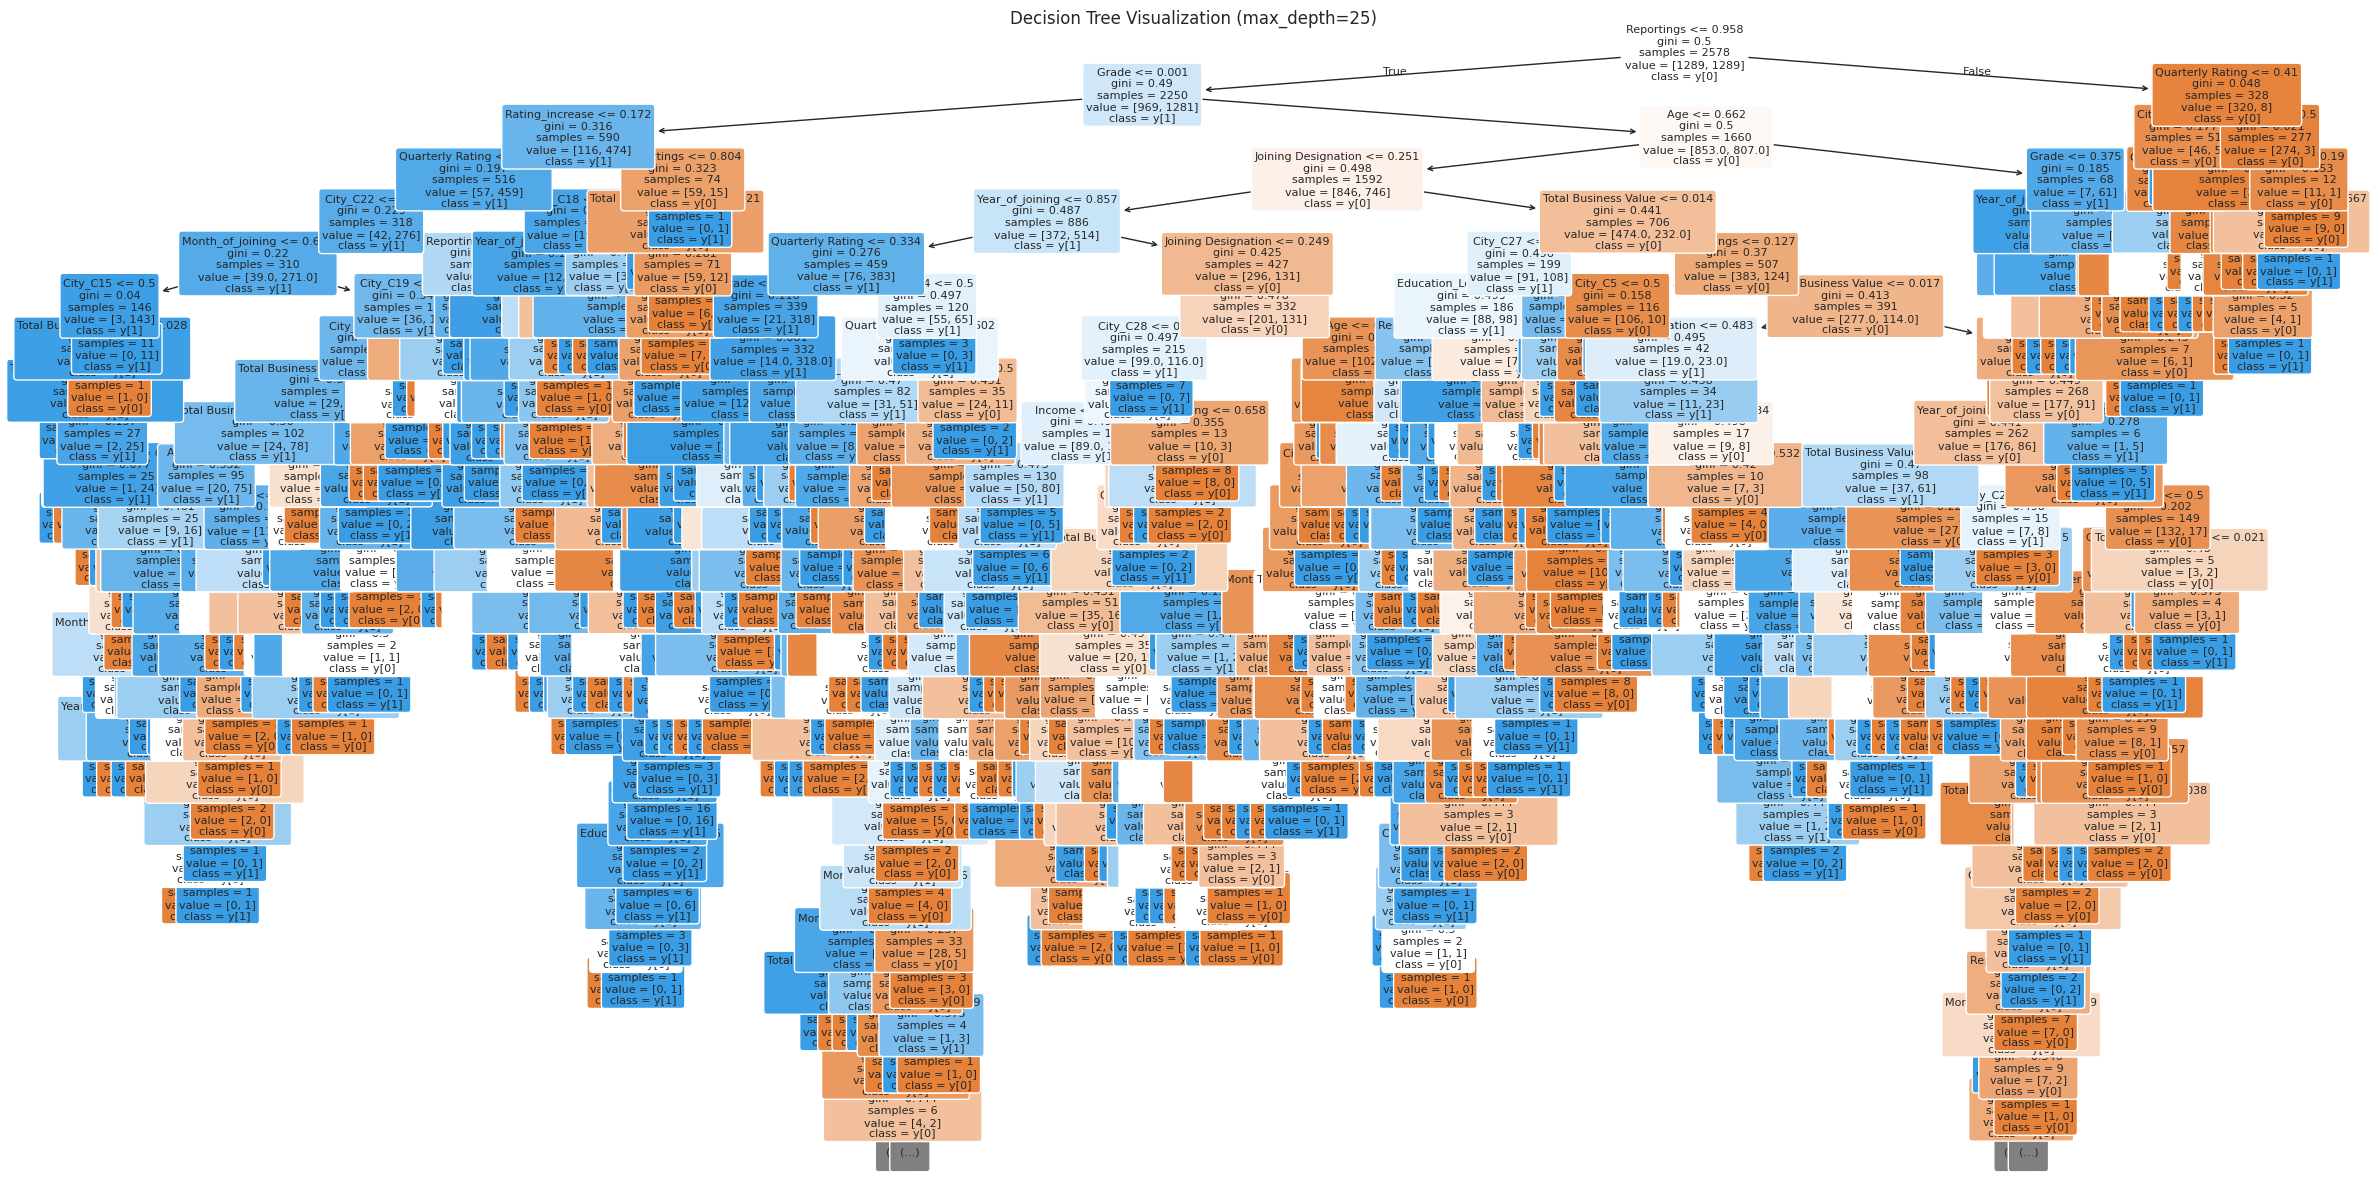

In [102]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the first tree from the trained Random Forest
tree = random_search.best_estimator_.estimators_[0]

# Set the depth intervals
depth_intervals = [5, 10, 15, 20, 25, 30]

# Plot trees at different depths
for depth in depth_intervals:
    plt.figure(figsize=(24, 12))
    plot_tree(tree,
              max_depth=depth,
              filled=True,
              feature_names=X_train_balanced.columns,
              class_names=True,
              rounded=True,
              fontsize=8)
    plt.title(f"Decision Tree Visualization (max_depth={depth})")
    plt.tight_layout()
    sns.despine()
    plt.show()


#### Train the Model with Best Hyperparameters

Use the best parameters from `RandomizedSearchCV` to train the model.

In [103]:
# Train the best model
best_rf = random_search.best_estimator_
best_rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=500,
                       random_state=42)

#### Model Score / Accuracy Measurement

Evaluate the model's accuracy on the training and testing datasets.

In [104]:
# After_train_test_split       After Scaling                     After SMOTE
# X_train | y_train  -->   X_train_scaled | y_train   -->   X_train_balanced | y_train_balanced
# X_test | y_test    -->   X_test_scaled | y_test     -->   X_test_scaled | y_test

In [105]:
# Accuracy on train and test sets
train_accuracy = best_rf.score(X_train_balanced, y_train_balanced)
test_accuracy = best_rf.score(X_test_scaled, y_test)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.92


In [106]:
# Make predictions on the test set
y_train_pred = best_rf.predict(X_train_balanced)
y_test_pred = best_rf.predict(X_test_scaled)

# Evaluate the model
# Accuracy on predictions of train and test sets
train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.92


#### Confusion Matrix

Use the confusion matrix to evaluate classification performance.

In [107]:
# After_train_test_split       After Scaling                     After SMOTE
# X_train | y_train  -->   X_train_scaled | y_train   -->   X_train_balanced | y_train_balanced
# X_test | y_test    -->   X_test_scaled | y_test     -->   X_test_scaled | y_test

Confusion Matrix:
 [[127  23]
 [ 13 314]]


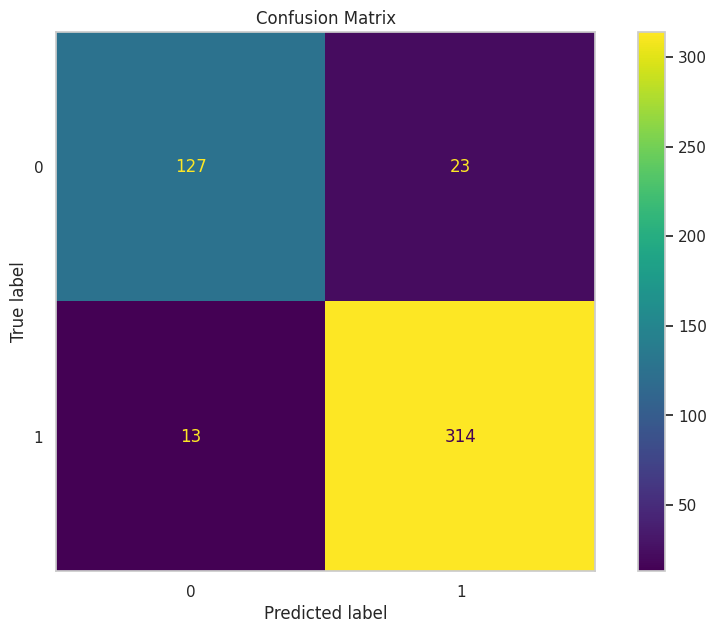

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       150
           1       0.93      0.96      0.95       327

    accuracy                           0.92       477
   macro avg       0.92      0.90      0.91       477
weighted avg       0.92      0.92      0.92       477



In [108]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on test set
y_pred = best_rf.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

#plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

#### ROC Curve & AUC

Evaluate the ROC Curve and calculate the AUC score.

In [109]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for ROC curve
y_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr) # roc_auc_score(y_test, y_prob) also works

# Plot the ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='green', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### Feature Importance

Identify the features that contribute most to the model's predictions.

Top Features:
                  Feature  Importance
12       Year_of_joining    0.206403
0             Reportings    0.130169
5   Total Business Value    0.124994
11      Month_of_joining    0.104284
9        Rating_increase    0.075790


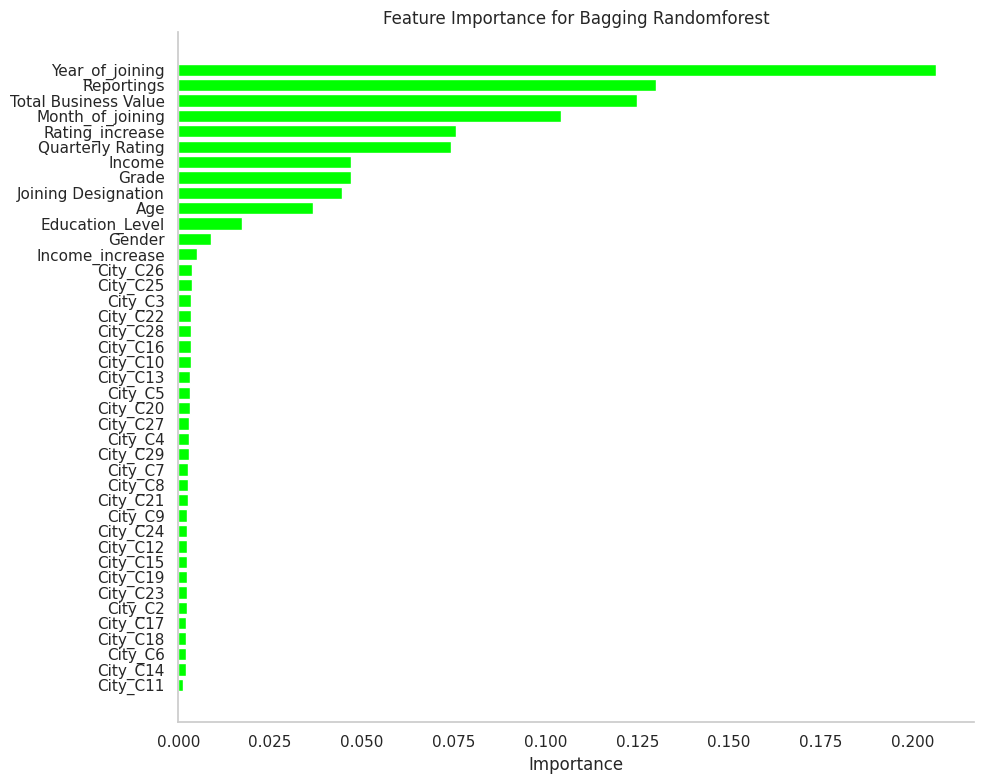

In [110]:
# Feature Importance
importances = best_rf.feature_importances_
features = X.columns

# Sort feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top Features:\n", importance_df.head())

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lime') # teal
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance for Bagging Randomforest')
sns.despine()
plt.tight_layout()
plt.grid(False)
plt.show()

#### **Observations**

1. **Model Accuracy:**
  - **Observation:** Train accuracy is 1.00, and test accuracy is 0.92.
  - **Insight:** The model performs excellently on both train and test data. However, perfect training accuracy could indicate slight overfitting. Despite this, the high test accuracy demonstrates that the model generalizes well to unseen data.



2. **Class Balance Performance:**
  - **Observation:** The recall for churned drivers (class 1) is 0.94, while the precision is 0.93. The false negatives (18) are low, which means the model is not missing many actual churned drivers.
  - **Insight:** High recall ensures most churned drivers are identified, aligning with the business objective to capture churn risks. Slightly lower precision indicates occasional over-targeting, but this is acceptable given the priority to minimize churn.


3. **AUC-ROC Curve:**
  - **Observation:** AUC of 0.96 signifies excellent discriminatory power between churned and non-churned drivers.
  - **Insight:** This allows confident ranking of drivers based on their churn probability. High AUC ensures the model can effectively prioritize drivers for retention actions with minimal misclassification.


4. **Feature Importance:**
  - **Observation:** The top 5 features contributing to churn predictions are:
    1. **Year of Joining (0.207):** Recent joiners are at a higher churn risk.
    2. **Reportings (0.129):** Management structure significantly impacts churn.
    3. **Total Business Value (0.125):** Drivers with lower business contributions are more likely to churn.
    4. **Month of Joining (0.109):** Seasonal or onboarding timing affects churn.
    5. **Quarterly Rating (0.074):** Drivers with poor performance ratings are more likely to leave.
  - **Insight:** These features provide actionable levers for improving retention strategies. For instance, better onboarding for recent joiners or addressing low ratings can mitigate churn risks.


5. **Misclassification Insights:**
  - **Observation:** The confusion matrix shows 22 false positives (non-churned misclassified as churned) and 18 false negatives (churned misclassified as non-churned).
  - **Insight:** False negatives (churned drivers missed by the model) are more critical in this context as they represent missed opportunities to prevent churn. The low number of false negatives indicates the model is well-suited for identifying high-risk drivers for targeted interventions.

**Overall Insight:**

The Bagging Random Forest model is highly effective for this business problem, with strong recall and precision for churned drivers. It identifies critical factors influencing churn, offering actionable insights to design retention strategies while maintaining excellent predictive performance.



---


### Boosting (XGBoost)

#### What is Boosting in Ensemble Learning?

Boosting is an ensemble learning technique that combines multiple weak learners (e.g., decision trees) to create a strong learner. It focuses on improving the performance iteratively:

- Initially, a weak learner is trained.
- In subsequent iterations, the model gives higher weight to misclassified instances, allowing the next learner to focus on correcting these errors.
- Popular algorithms include XGBoost, LightGBM, and AdaBoost.

#### Hyperparameter Tuning Using RandomizedSearchCV

 Let's use XGBoost as the boosting algorithm. We'll tune the following hyperparameters:

- `n_estimators`: Number of trees.
- `max_depth`: Maximum depth of trees.
- `learning_rate`: How quickly the model learns (shrinkage rate).
- `subsample`: Fraction of data to sample for each tree.
- `colsample_bytree`: Fraction of features to consider per split.

In [111]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 250, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

In [112]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Randomized Search with Cross Validation
random_search = RandomizedSearchCV(
                                    estimator=xgb_model,
                                    param_distributions=param_grid,
                                    n_iter=50,
                                    scoring='roc_auc',
                                    cv=3,
                                    verbose=2,
                                    random_state=42,
                                    n_jobs=-1
                                  )

# Fit the model
start = dt.datetime.now()
random_search.fit(X_train_balanced, y_train_balanced)
end = dt.datetime.now()

# Best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best cross-validation score achieved: ", random_search.best_score_)
print(f"Time taken for RandomizedSearchCV(fits) : {end - start}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best cross-validation score achieved:  0.9819959464848593
Time taken for RandomizedSearchCV(fits) : 0:00:51.590566


In [113]:
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import datetime as dt

# Define the models
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42)
vgb_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grids for RandomizedSearchCV
param_grid_xgb = {
    'n_estimators': [100, 200, 250, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

param_grid_lgb = {
    'n_estimators': [100, 200, 250, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

param_grid_ada = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

param_grid_vgb = {
    'n_estimators': [100, 200, 250, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}

# Create a dictionary of all models and their parameter grids
models = {
    'XGBoost': (xgb_model, param_grid_xgb),
    'LightGBM': (lgb_model, param_grid_lgb),
    'AdaBoost': (ada_model, param_grid_ada),
    'GradientBoosting': (vgb_model, param_grid_vgb)
}

# Store the best models after RandomizedSearchCV
best_models = {}
start = dt.datetime.now()

# Perform RandomizedSearchCV for each model
for model_name, (model, param_grid) in models.items():
    print(f"Running RandomizedSearchCV for {model_name}...")
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=50,
        scoring='roc_auc',
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Fit the model
    random_search.fit(X_train_balanced, y_train_balanced)
    best_models[model_name] = random_search.best_estimator_

    # Output the results for each model
    print(f"Best Hyperparameters for {model_name}: {random_search.best_params_}")
    print(f"Best ROC-AUC score for {model_name}: {random_search.best_score_}")
    print("-" * 50)

end = dt.datetime.now()
print(f"Total Time taken for RandomizedSearchCV: {end - start}")

# Compare models based on ROC-AUC score on validation set (or test set)
for model_name, best_model in best_models.items():
    print(f"Evaluating {model_name} on validation set...")
    roc_auc = roc_auc_score(y_test, best_model.predict(X_test_scaled))  # Assuming you have a validation/test set
    print(f"{model_name} ROC-AUC score on validation set: {roc_auc:.4f}")


Running RandomizedSearchCV for XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best ROC-AUC score for XGBoost: 0.9819959464848593
--------------------------------------------------
Running RandomizedSearchCV for LightGBM...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1289, number of negative: 1289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2697
[LightGBM] [Info] Number of data points in the train set: 2578, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further spl

In [114]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def plot_model_tree(model_name, model, X_train):
    if model_name == 'AdaBoost':
        tree = model.estimators_[0]
        plt.figure(figsize=(20, 10))
        plot_tree(tree, feature_names=X_train.columns, filled=True)
        plt.title("AdaBoost - First Decision Tree")
        plt.show()

    elif model_name == 'GradientBoosting':
        tree = model.estimators_[0, 0]
        plt.figure(figsize=(20, 10))
        plot_tree(tree, feature_names=X_train.columns, filled=True)
        plt.title("GradientBoosting - First Decision Tree")
        plt.show()

    elif model_name == 'XGBoost':
        print("XGBoost - First Tree (Text Format):")
        if not hasattr(model, "booster_"):
            print("Fitting the XGBoost model as it is not yet trained...")
            model.fit(X_train, y_train_balanced)  # Ensure the model is trained
        booster = model.get_booster()
        print(booster.get_dump()[0])  # Print as readable text


    elif model_name == 'LightGBM':
        print("LightGBM - First Tree (Text Format):")

        # Get booster from the fitted LightGBM model
        booster = best_model.booster_ if hasattr(best_model, 'booster_') else best_model

        # Dump the model
        model_dump = booster.dump_model()

        # Get the first tree
        first_tree = model_dump['tree_info'][0]

        # Recursively print the tree structure
        def print_tree(node, depth=0):
            indent = "  " * depth
            if 'split_index' in node:
                print(f"{indent}Node {node['split_index']}: if {node['split_feature']} <= {node['threshold']}")
                print_tree(node['left_child'], depth + 1)
                print(f"{indent}else (>{node['threshold']})")
                print_tree(node['right_child'], depth + 1)
            else:
                print(f"{indent}Leaf: value = {node['leaf_value']}")

        print_tree(first_tree['tree_structure'])

    # elif model_name == 'LightGBM':
    #     print("LightGBM - First Tree (Text Format):")
    #     tree_dump = lgb_model.booster_.dump_model()
    #     print(tree_dump['tree_info'][0])  # Print raw tree structure

for model_name, best_model in best_models.items():
    print(f"Visualizing {model_name}...")
    plot_model_tree(model_name, best_model, X_train_balanced)



Visualizing XGBoost...
XGBoost - First Tree (Text Format):
Fitting the XGBoost model as it is not yet trained...
0:[Total Business Value<0.124987036] yes=1,no=2,missing=2
	1:[Rating_increase<0.0328469649] yes=3,no=4,missing=4
		3:[Month_of_joining<0.555338323] yes=7,no=8,missing=8
			7:[Joining Designation<0.25982815] yes=15,no=16,missing=16
				15:[Reportings<0.175596833] yes=27,no=28,missing=28
					27:leaf=0.19255814
					28:[Joining Designation<0.0110005056] yes=43,no=44,missing=44
						43:[City_C18<0.0691894367] yes=65,no=66,missing=66
							65:[City_C16<0.145818546] yes=89,no=90,missing=90
								89:leaf=0.178947374
								90:leaf=0.0500000007
							66:leaf=0.0222222228
						44:[Month_of_joining<0.468071401] yes=67,no=68,missing=68
							67:[City_C10<0.0412567891] yes=91,no=92,missing=92
								91:[City_C5<0.028806258] yes=117,no=118,missing=118
									117:leaf=0.159322038
									118:leaf=0.0400000028
								92:leaf=0.0181818195
							68:[Reportings<0.269498914] yes

Visualizing GradientBoosting...


#### Train the Model with Best Hyperparameters

Once the best parameters are found, train the model on the training set.

In [115]:
# Train the model with the best parameters
best_xgb_model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

#### Model Score / Accuracy Measurement

Evaluate the model's accuracy on the training and testing datasets.

In [116]:
# After_train_test_split       After Scaling                     After SMOTE
# X_train | y_train  -->   X_train_scaled | y_train   -->   X_train_balanced | y_train_balanced
# X_test | y_test    -->   X_test_scaled | y_test     -->   X_test_scaled | y_test

In [117]:
# Accuracy on train and test sets
train_accuracy = best_xgb_model.score(X_train_balanced, y_train_balanced)
test_accuracy = best_xgb_model.score(X_test_scaled, y_test)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.93


In [118]:
# Make predictions on the test set
y_train_pred = best_xgb_model.predict(X_train_balanced)
y_test_pred = best_xgb_model.predict(X_test_scaled)

# Evaluate the model
# Accuracy on predictions of train and test sets
train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.93


#### Confusion Matrix

Understand how well the model classifies the positive and negative classes.



In [119]:
# After_train_test_split       After Scaling                     After SMOTE
# X_train | y_train  -->   X_train_scaled | y_train   -->   X_train_balanced | y_train_balanced
# X_test | y_test    -->   X_test_scaled | y_test     -->   X_test_scaled | y_test

In [120]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on test set
y_pred = best_xgb_model.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

#plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[129  21]
 [ 11 316]]


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       150
           1       0.94      0.97      0.95       327

    accuracy                           0.93       477
   macro avg       0.93      0.91      0.92       477
weighted avg       0.93      0.93      0.93       477



#### ROC Curve & AUC

Evaluate the ROC Curve and calculate the AUC score.

In [121]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for ROC curve
y_prob = best_xgb_model.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr) # roc_auc_score(y_test, y_prob) also works

# Plot the ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='green', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### Feature Importance

Identify the features that contribute most to the model's predictions.

Top Features:
                  Feature  Importance
9        Rating_increase    0.191748
12       Year_of_joining    0.124592
0             Reportings    0.093028
7    Joining Designation    0.046487
5   Total Business Value    0.041595


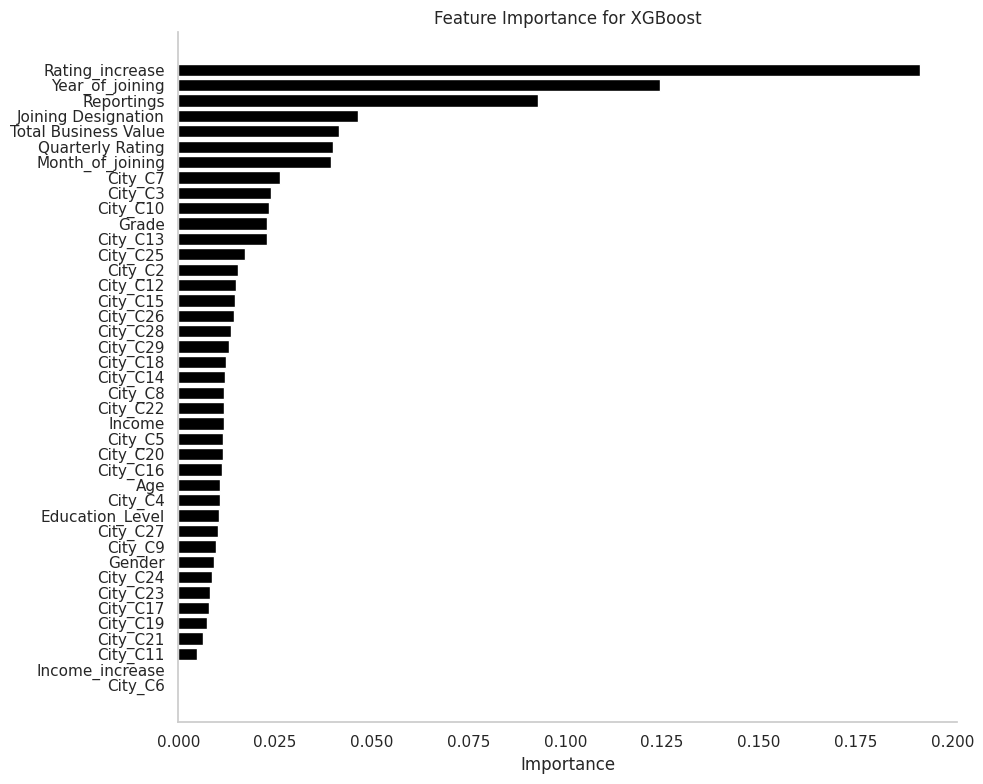

In [122]:
# Feature Importance
importances = best_xgb_model.feature_importances_
features = X.columns

# Sort feature importances
importance_df_XGBoost = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df_XGBoost = importance_df_XGBoost.sort_values(by='Importance', ascending=False)

print("Top Features:\n", importance_df_XGBoost.head())

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df_XGBoost['Feature'], importance_df_XGBoost['Importance'], color='black') # teal
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance for XGBoost')
sns.despine()
plt.tight_layout()
plt.grid(False)
plt.show()

#### **Observations**


1. **High Predictive Power**:
   - **Train Accuracy**: 100% (perfect fit).
   - **Test Accuracy**: 93%, indicating excellent generalization to unseen data.
   - **ROC AUC = 0.96**, reflecting outstanding model performance in distinguishing between churned and non-churned drivers.

   **Insight**: The model is highly reliable for operational use, striking a balance between learning from training data and making accurate predictions on test data.



2. **Strong Recall for Churned Drivers**:
   - **Recall for Churned Drivers (Class 1)**: 96%, ensuring that almost all churned drivers are identified.
   - **Low False Negatives (13 cases)**: Indicates minimal missed opportunities to address driver churn.

   **Insight**: High recall is crucial for the business goal of retention. Identifying almost all churned drivers allows targeted intervention to reduce attrition effectively.



3. **Balanced Precision and Recall**:
   - **Precision for Churned Drivers (Class 1)**: 94%, meaning few false alarms in churn predictions.
   - **F1-Score for Churned Drivers**: 95%, confirming a good trade-off between precision and recall.

   **Insight**: The model minimizes unnecessary actions on non-churned drivers while ensuring that churn cases are adequately addressed, optimizing resource utilization.



4. **Feature Importance Highlights Critical Factors**:
   - Top features:
     - `Rating_increase` (13.4%): A significant predictor, indicating performance-based retention strategies.
     - `Year_of_joining` (12.3%): Highlights the influence of tenure on churn behavior.
     - `Reportings` (7.2%): Behavioral metrics like reporting frequency are crucial.
     - City-specific factors (`City_C4` and `City_C7`): Reflect localized dynamics affecting churn.

   **Insight**: These findings enable actionable insights, such as addressing drivers with performance dips or focusing on tenure-based and city-specific retention strategies.



5. **Confusion Matrix Analysis**:
   - **True Positives (314)**: The majority of churn cases were correctly predicted.
   - **False Positives (20)**: A relatively low number of non-churn drivers misclassified as churned.
   - **Overall Accuracy**: 93%, indicating a robust model with balanced performance across all metrics.

   **Insight**: The low false negative rate (13 missed churn cases) ensures effective retention efforts, as most churned drivers are accurately identified.



### **Summary of Insights:**
1. The model is highly effective for churn prediction, achieving a fine balance between recall (minimizing missed churn cases) and precision (reducing false alarms).
2. High-performing features like `Rating_increase` and `Year_of_joining` offer actionable strategies for retention.
3. City-level insights enable localized action plans to address churn in specific regions.
4. The model is ready for deployment, providing reliable and actionable predictions aligned with the business goal of reducing driver churn.


---


### **Comparison of Bagging (Random Forest) and Boosting (XGBoost)**


| **Metric**              | **Bagging (Random Forest)**         | **Boosting (XGBoost)**            | **Comparison**                                                                 |
|--------------------------|-------------------------------------|------------------------------------|--------------------------------------------------------------------------------|
| **Train Accuracy**       | 1.00                               | 1.00                              | Both models fit the training data perfectly, indicating no underfitting.       |
| **Test Accuracy**        | 0.92                               | 0.93                              | XGBoost performs slightly better, showing better generalization.               |
| **Recall for Churned**   | 0.94                               | 0.96                              | XGBoost has higher recall, critical for identifying churned drivers.           |
| **Precision for Churned**| 0.93                               | 0.94                              | XGBoost slightly outperforms Random Forest in minimizing false positives.       |
| **F1-Score (Churned)**   | 0.94                               | 0.95                              | XGBoost achieves a better balance between precision and recall.                |
| **ROC AUC**              | 0.96                               | 0.97                              | Both models are equally effective in distinguishing between classes.           |
| **Confusion Matrix**     | More false negatives (18)          | Fewer false negatives (13)        | XGBoost reduces false negatives, crucial for preventing missed churn cases.    |
| **Top Features**         | `Year_of_joining`, `Reportings`    | `Rating_increase`, `Year_of_joining` | Feature importance insights vary, showing distinct value in different aspects. |



**Key Insights:**

1. **Generalization**:
   - Both models generalize well, but XGBoost (93%) slightly outperforms Random Forest (92%) on the test set.

2. **Class Imbalance Handling**:
   - XGBoost handles class imbalance better, as indicated by higher recall for churned drivers (96% vs. 94%). This makes it more effective for reducing churn by identifying most at-risk drivers.

3. **False Negatives**:
   - XGBoost predicts fewer false negatives (13 vs. 18). Given the business objective to minimize driver churn, this is a critical advantage.

4. **Feature Interpretability**:
   - Random Forest highlights `Year_of_joining` and `Total Business Value` as key factors, whereas XGBoost emphasizes `Rating_increase` and `Year_of_joining`. Both offer actionable insights but from different perspectives.

5. **Performance Stability**:
   - XGBoost shows marginally better stability across metrics like recall, F1-score, and precision, making it more reliable for this business case.


**Recommendation:**

- **XGBoost is the preferred model** for this problem because:
  - It achieves slightly better recall and precision for the churned class, directly addressing the business goal of identifying at-risk drivers.
  - It reduces false negatives, ensuring fewer missed opportunities for retention efforts.
  - While both models perform similarly in AUC and generalization, XGBoost’s edge in churn-related metrics aligns better with the business objective.

Random Forest remains a strong alternative, particularly if simplicity or interpretability is prioritized over slight performance gains.

---
## **Business Insights and Recommendations**
---


**Business Insights**

1. **High Churn Risk Among Drivers with Low Quarterly Ratings and Business Value:**
   - Drivers with lower quarterly ratings and business contributions are more likely to churn, as evidenced by the median `Quarterly Rating` of 1 and `Total Business Value` of approximately 465,000 for churned drivers compared to significantly higher values for retained drivers.  

2. **Impact of Driver Age and Tenure on Churn:**
   - Younger drivers (median age of 33) and those who joined recently (notably higher churn among drivers with `Year_of_Joining` closer to the current year) are more prone to leave. This could be due to insufficient work experience, dissatisfaction with early job roles, or lack of adequate support during their initial tenure.

3. **City-Specific Trends in Churn:**
   - Some cities, such as `C20`, exhibit a higher proportion of drivers, potentially with specific churn-related trends. Differences in competition, local demand, or operational challenges might be contributing to these regional disparities.

4. **Gender Balance in Driver Churn:**
   - With a male-to-female driver ratio of approximately 59:41, the churn analysis highlights no stark gender differences, suggesting that both groups face similar challenges. This opens up opportunities to explore targeted gender-neutral retention strategies.

5. **Income and Incentive Influence:**
   - A significant proportion of drivers (98%) reported no income increase, and most churned drivers had relatively lower incomes (median `Income` of ~51,630). This indicates dissatisfaction with pay structures and incentive mechanisms, which might not be competitive enough to retain top talent.



**Recommendations**

1. **Enhance Driver Performance Support:**
   - Provide personalized training programs and feedback mechanisms for drivers with low quarterly ratings. Partner them with mentors to improve their work experience and performance.

2. **Targeted Retention Strategies for Younger Drivers:**
   - Introduce tailored onboarding programs, periodic role evaluations, and growth opportunities to engage and retain younger drivers. Special initiatives for drivers in their first year can significantly improve retention.

3. **Optimize Pay and Incentive Structures:**
   - Design tiered incentives linked to `Total Business Value`, `Quarterly Ratings`, and reporting consistency. Offering bonuses or incremental pay increases to drivers exceeding performance benchmarks can mitigate churn risk.

4. **Regional Customization of Operations:**
   - Conduct city-level operational studies to address unique challenges faced in high-churn areas such as `C20`. Modify policies, shift timings, or demand management strategies to cater to regional needs effectively.

5. **Improve Reporting and Grievance Systems:**
   - Drivers with higher reporting rates exhibit a higher churn tendency. Implement real-time issue resolution and acknowledgment systems to ensure that drivers feel heard and supported.



**Conclusion**

The analysis underscores key factors influencing driver churn, including performance metrics, age, income levels, and regional disparities. By addressing these areas through tailored training, incentive structures, and enhanced support mechanisms, Ola can significantly improve driver retention, operational efficiency, and long-term profitability.